In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import  LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [2]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [3]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

open    high     low   close    volume
date                                                         
2023-06-28 19:45:00  336.80  336.95  336.00  336.50    3996.0
2023-06-28 19:30:00  337.10  337.28  336.76  337.00    3447.0
2023-06-28 19:15:00  337.29  337.40  336.72  337.10    5028.0
2023-06-28 19:00:00  337.20  337.29  336.91  337.29    2537.0
2023-06-28 18:45:00  337.19  337.26  335.85  337.20  222687.0
...                     ...     ...     ...     ...       ...
2023-05-31 05:00:00  332.27  333.14  332.27  332.66    5894.0
2023-05-31 04:45:00  331.89  332.23  331.73  332.23    3495.0
2023-05-31 04:30:00  332.50  332.59  331.77  331.80    4428.0
2023-05-31 04:15:00  332.26  333.00  332.21  332.58    7099.0
2023-05-31 04:00:00  330.80  333.00  330.47  332.13   18051.0

[1280 rows x 5 columns]

# INDICATORS CALCULATION

In [4]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [5]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

ROC
date                       
2023-05-31 09:00:00  0.1626
2023-05-31 09:15:00 -0.0872
2023-05-31 09:30:00  0.8409
2023-05-31 09:45:00  0.7465
2023-05-31 10:00:00  0.0150
...                     ...
2023-06-28 18:45:00  0.5967
2023-06-28 19:00:00  0.4587
2023-06-28 19:15:00  0.4140
2023-06-28 19:30:00  0.4737
2023-06-28 19:45:00  0.4028

[1260 rows x 1 columns]

## 2. Simple Moving Average (SMA)

In [6]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

SMA
date                         
2023-05-31 08:45:00  332.4100
2023-05-31 09:00:00  332.4370
2023-05-31 09:15:00  332.4225
2023-05-31 09:30:00  332.5620
2023-05-31 09:45:00  332.6860
...                       ...
2023-06-28 18:45:00  336.1358
2023-06-28 19:00:00  336.2128
2023-06-28 19:15:00  336.2823
2023-06-28 19:30:00  336.3617
2023-06-28 19:45:00  336.4293

[1261 rows x 1 columns]

## 3. Relative Strength Index (RSI)

In [7]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

RSI
date                        
2023-05-31 09:00:00  54.1284
2023-05-31 09:15:00  51.0086
2023-05-31 09:30:00  64.1671
2023-05-31 09:45:00  64.6879
2023-05-31 10:00:00  51.5432
...                      ...
2023-06-28 18:45:00  59.1992
2023-06-28 19:00:00  59.7600
2023-06-28 19:15:00  57.9889
2023-06-28 19:30:00  57.0521
2023-06-28 19:45:00  52.5814

[1260 rows x 1 columns]

## 4. Bolling Bands (BBANDS)

In [8]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [9]:
# indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
# indicator_bb = indicator_bb[0]
# indicator_bb

**Merge indicators to data**

In [10]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

open    high      low    close     volume     ROC  \
date                                                                       
2023-05-31 09:00:00  332.00  332.91  331.950  332.670    38541.0  0.1626   
2023-05-31 09:15:00  332.67  332.78  331.280  332.290    74220.0 -0.0872   
2023-05-31 09:30:00  332.29  334.90  331.450  334.590  2789882.0  0.8409   
2023-05-31 09:45:00  334.61  335.94  334.254  334.710  1711224.0  0.7465   
2023-05-31 10:00:00  334.73  334.99  332.680  332.710  1404624.0  0.0150   
...                     ...     ...      ...      ...        ...     ...   
2023-06-28 14:00:00  335.29  335.97  335.080  335.750   433864.0  0.2538   
2023-06-28 14:15:00  335.74  336.18  335.670  335.710   413379.0  0.3527   
2023-06-28 14:30:00  335.68  335.89  335.080  335.411   365289.0  0.1436   
2023-06-28 14:45:00  335.39  335.47  335.000  335.150   334694.0 -0.1103   
2023-06-28 15:00:00  335.19  335.22  333.810  334.910   628109.0  0.1555   

                          SMA      RSI  Real Middle Band  Real Lower Band  \
date                                                                        
2023-05-31 09:00:00  332.4370  54.1284          332.4370       328.777697   
2023-05-31 09:15:00  332.4225  51.0086          332.4225       328.848252   
2023-05-31 09:30:00  332.5620  64.1671          332.5620       329.045249   
2023-05-31 09:45:00  332.6860  64.6879          332.6860       329.456135   
2023-05-31 10:00:00  332.6885  51.5432          332.6885       330.219814   
...                       ...      ...               ...              ...   
2023-06-28 14:00:00  335.8830  51.5569          335.8830       332.923870   
2023-06-28 14:15:00  335.9420  51.3458          335.9420       332.912704   
2023-06-28 14:30:00  335.9661  49.7436          335.9661       332.882151   
2023-06-28 14:45:00  335.9476  48.3571          335.9476       332.826285   
2023-06-28 15:00:00  335.9736  47.0868          335.9736       332.861597   

                     Real Upper Band  
date                                  
2023-05-31 09:00:00       336.096303  
2023-05-31 09:15:00       335.996748  
2023-05-31 09:30:00       336.078751  
2023-05-31 09:45:00       335.915865  
2023-05-31 10:00:00       335.157186  
...                              ...  
2023-06-28 14:00:00       338.842130  
2023-06-28 14:15:00       338.971296  
2023-06-28 14:30:00       339.050049  
2023-06-28 14:45:00       339.068915  
2023-06-28 15:00:00       339.085603  

[1241 rows x 11 columns]

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [11]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[332.67 ],
       [332.29 ],
       [334.59 ],
       ...,
       [335.411],
       [335.15 ],
       [334.91 ]])

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.36955064],
       [0.35680751],
       [0.43393696],
       ...,
       [0.46146881],
       [0.4527163 ],
       [0.44466801]])

In [13]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1181
1181


In [14]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (945, 60, 1)
Size validate:  (118, 60, 1)
Size test:  (118, 60, 1)


### b. Train Model

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0378 - val_loss: 0.0100
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 9/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/

### c. Test Model

In [16]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [17]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open    high     low    close    volume     ROC  \
1123  2023-06-26 17:45:00  328.80  329.19  328.61  328.950    1455.0 -0.4419   
1124  2023-06-26 18:00:00  329.19  329.42  328.79  329.003    3559.0 -0.2991   
1125  2023-06-26 18:15:00  329.13  329.29  328.79  328.790    2136.0 -0.4333   
1126  2023-06-26 18:30:00  328.90  329.05  328.79  329.010    1509.0 -0.2637   
1127  2023-06-26 18:45:00  329.00  329.29  328.81  328.820     954.0 -0.3485   
...                   ...     ...     ...     ...      ...       ...     ...   
1236  2023-06-28 14:00:00  335.29  335.97  335.08  335.750  433864.0  0.2538   
1237  2023-06-28 14:15:00  335.74  336.18  335.67  335.710  413379.0  0.3527   
1238  2023-06-28 14:30:00  335.68  335.89  335.08  335.411  365289.0  0.1436   
1239  2023-06-28 14:45:00  335.39  335.47  335.00  335.150  334694.0 -0.1103   
1240  2023-06-28 15:00:00  335.19  335.22  333.81  334.910  628109.0  0.1555   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1123  329.5335  36.6679          329.5335       328.604611       330.462389   
1124  329.4842  37.1343          329.4842       328.521674       330.446726   
1125  329.4126  36.0125          329.4126       328.422429       330.402771   
1126  329.3691  38.0473          329.3691       328.419998       330.318202   
1127  329.3116  36.9783          329.3116       328.430008       330.193192   
...        ...      ...               ...              ...              ...   
1236  335.8830  51.5569          335.8830       332.923870       338.842130   
1237  335.9420  51.3458          335.9420       332.912704       338.971296   
1238  335.9661  49.7436          335.9661       332.882151       339.050049   
1239  335.9476  48.3571          335.9476       332.826285       339.068915   
1240  335.9736  47.0868          335.9736       332.861597       339.085603   

      predictions  
1123   329.228638  
1124   329.195862  
1125   329.193207  
1126   329.183380  
1127   329.198273  
...           ...  
1236   335.795166  
1237   335.713409  
1238   335.710510  
1239   335.713654  
1240   335.688599  

[118 rows x 13 columns]

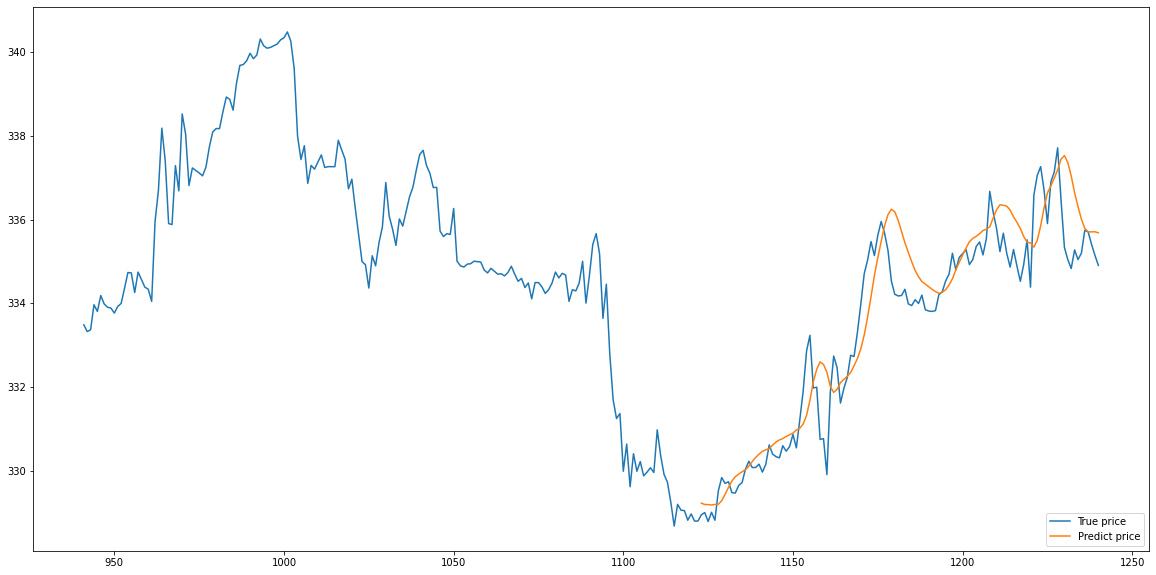

In [19]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [20]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.32670e+02,  1.62600e-01],
       [ 3.32290e+02, -8.72000e-02],
       [ 3.34590e+02,  8.40900e-01],
       ...,
       [ 3.35411e+02,  1.43600e-01],
       [ 3.35150e+02, -1.10300e-01],
       [ 3.34910e+02,  1.55500e-01]])

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.36955064, 0.50238509],
       [0.35680751, 0.46253251],
       [0.43393696, 0.6105997 ],
       ...,
       [0.46146881, 0.49935387],
       [0.4527163 , 0.45884718],
       [0.44466801, 0.50125237]])

In [22]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1181
1181


In [23]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (945, 60, 2)
Size validate:  (118, 60, 2)
Size test:  (118, 60, 2)


In [24]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.0302 - val_loss: 0.0036
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 11/

In [25]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [26]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

array([329.18674, 329.12347, 329.07074, 328.96692, 328.90335, 328.81924,
       328.8341 , 328.93948, 328.98203, 329.05106, 329.10764, 329.15808,
       329.25208, 329.38776, 329.52438, 329.67755, 329.7854 , 329.8704 ,
       329.9281 , 329.9436 , 329.9655 , 330.04587, 330.09818, 330.14005,
       330.1494 , 330.20615, 330.20242, 330.18362, 330.22687, 330.23956,
       330.37207, 330.64487, 331.0833 , 331.58762, 331.81494, 331.90155,
       331.7191 , 331.46628, 331.07376, 331.02353, 331.23688, 331.4606 ,
       331.55063, 331.6433 , 331.76373, 331.94473, 332.1302 , 332.38263,
       332.7178 , 333.1872 , 333.64465, 334.0653 , 334.28983, 334.48703,
       334.8122 , 335.08072, 335.31836, 335.3574 , 335.31647, 335.06696,
       334.731  , 334.47806, 334.3063 , 334.1626 , 334.06833, 333.96323,
       333.92374, 333.82227, 333.68015, 333.5124 , 333.366  , 333.30634,
       333.3479 , 333.44965, 333.58447, 333.8334 , 334.05862, 334.34756,
       334.64328, 334.90515, 335.0387 , 335.10107, 

In [27]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open    high     low    close    volume     ROC  \
1123  2023-06-26 17:45:00  328.80  329.19  328.61  328.950    1455.0 -0.4419   
1124  2023-06-26 18:00:00  329.19  329.42  328.79  329.003    3559.0 -0.2991   
1125  2023-06-26 18:15:00  329.13  329.29  328.79  328.790    2136.0 -0.4333   
1126  2023-06-26 18:30:00  328.90  329.05  328.79  329.010    1509.0 -0.2637   
1127  2023-06-26 18:45:00  329.00  329.29  328.81  328.820     954.0 -0.3485   
...                   ...     ...     ...     ...      ...       ...     ...   
1236  2023-06-28 14:00:00  335.29  335.97  335.08  335.750  433864.0  0.2538   
1237  2023-06-28 14:15:00  335.74  336.18  335.67  335.710  413379.0  0.3527   
1238  2023-06-28 14:30:00  335.68  335.89  335.08  335.411  365289.0  0.1436   
1239  2023-06-28 14:45:00  335.39  335.47  335.00  335.150  334694.0 -0.1103   
1240  2023-06-28 15:00:00  335.19  335.22  333.81  334.910  628109.0  0.1555   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1123  329.5335  36.6679          329.5335       328.604611       330.462389   
1124  329.4842  37.1343          329.4842       328.521674       330.446726   
1125  329.4126  36.0125          329.4126       328.422429       330.402771   
1126  329.3691  38.0473          329.3691       328.419998       330.318202   
1127  329.3116  36.9783          329.3116       328.430008       330.193192   
...        ...      ...               ...              ...              ...   
1236  335.8830  51.5569          335.8830       332.923870       338.842130   
1237  335.9420  51.3458          335.9420       332.912704       338.971296   
1238  335.9661  49.7436          335.9661       332.882151       339.050049   
1239  335.9476  48.3571          335.9476       332.826285       339.068915   
1240  335.9736  47.0868          335.9736       332.861597       339.085603   

      predictions  
1123   329.186737  
1124   329.123474  
1125   329.070740  
1126   328.966919  
1127   328.903351  
...           ...  
1236   335.223938  
1237   335.277252  
1238   335.396454  
1239   335.437500  
1240   335.356415  

[118 rows x 13 columns]

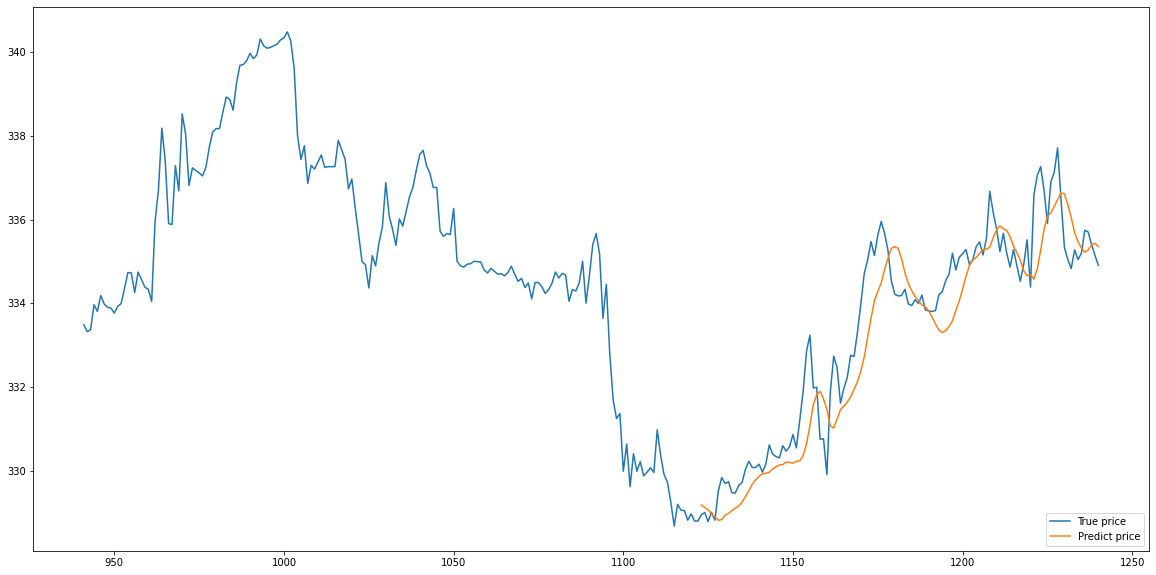

In [28]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.0175 - val_loss: 0.0054
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


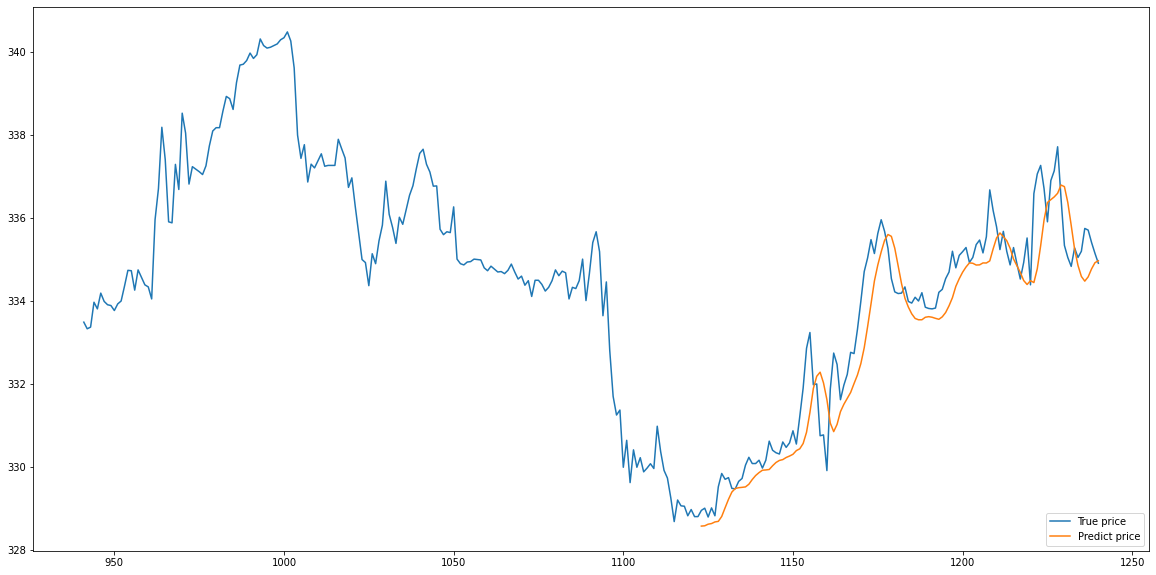

In [29]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.0238 - val_loss: 0.0032
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


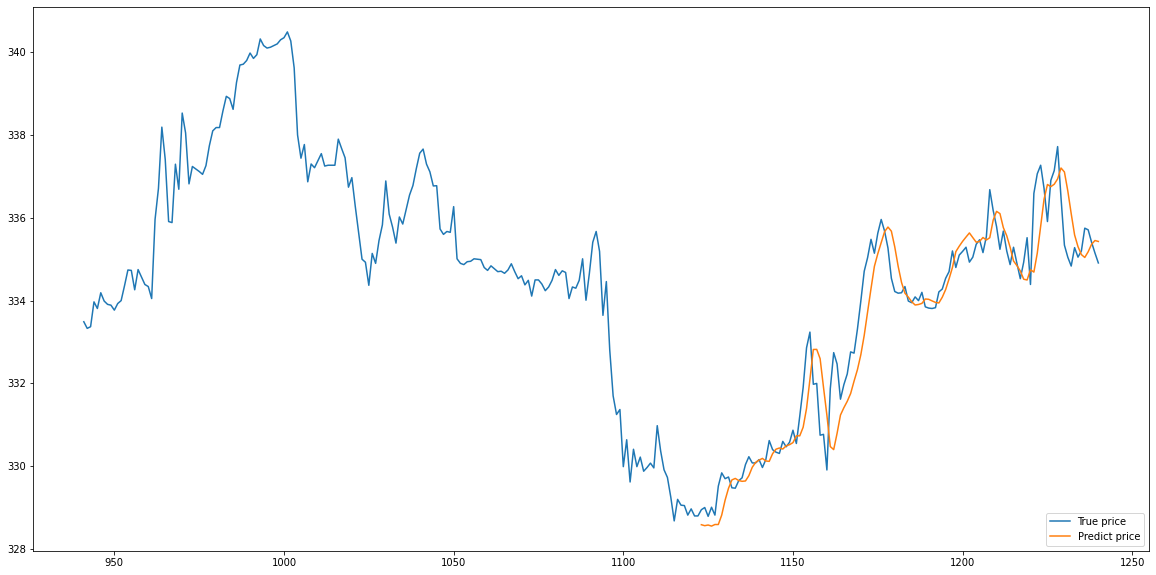

In [30]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0081 - val_loss: 0.0018
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 9.5653e-04
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 9.2493e-04
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0011
E

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


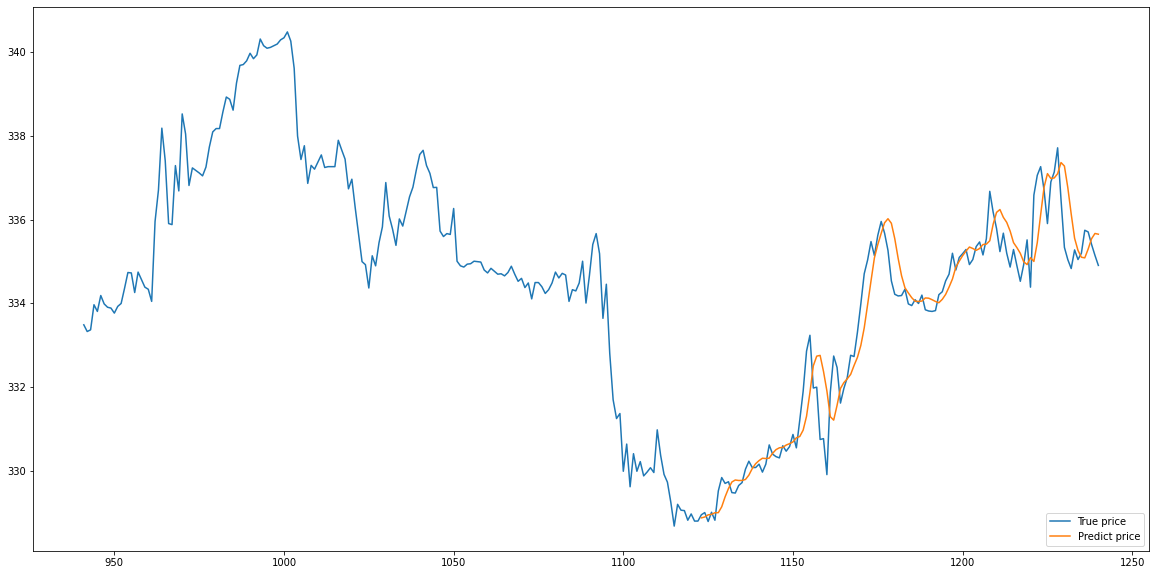

In [31]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0554 - val_loss: 0.0066
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


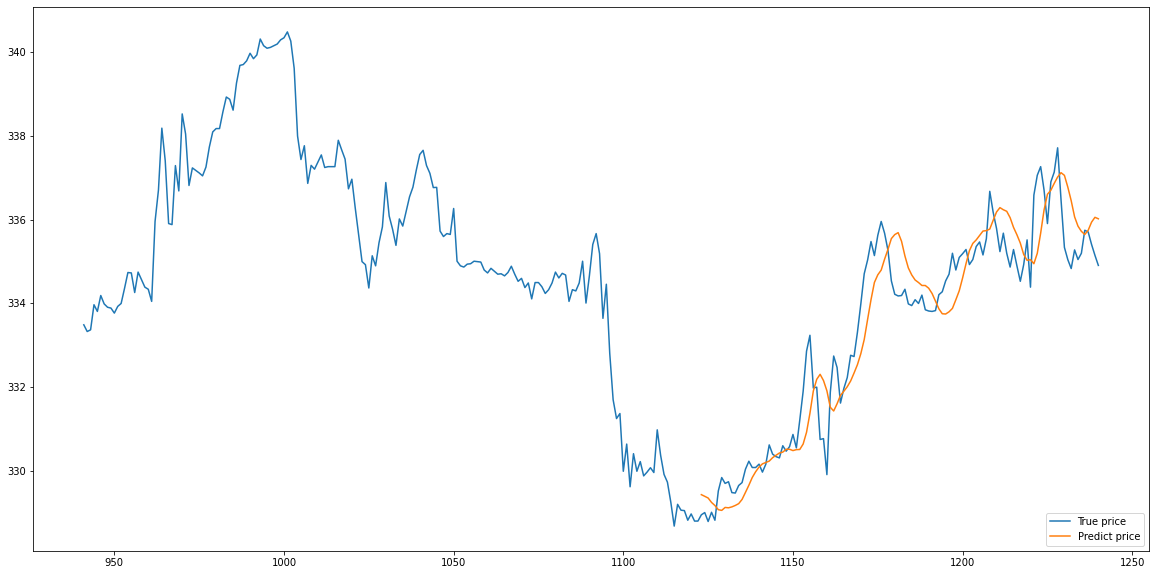

In [32]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0248 - val_loss: 0.0035
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


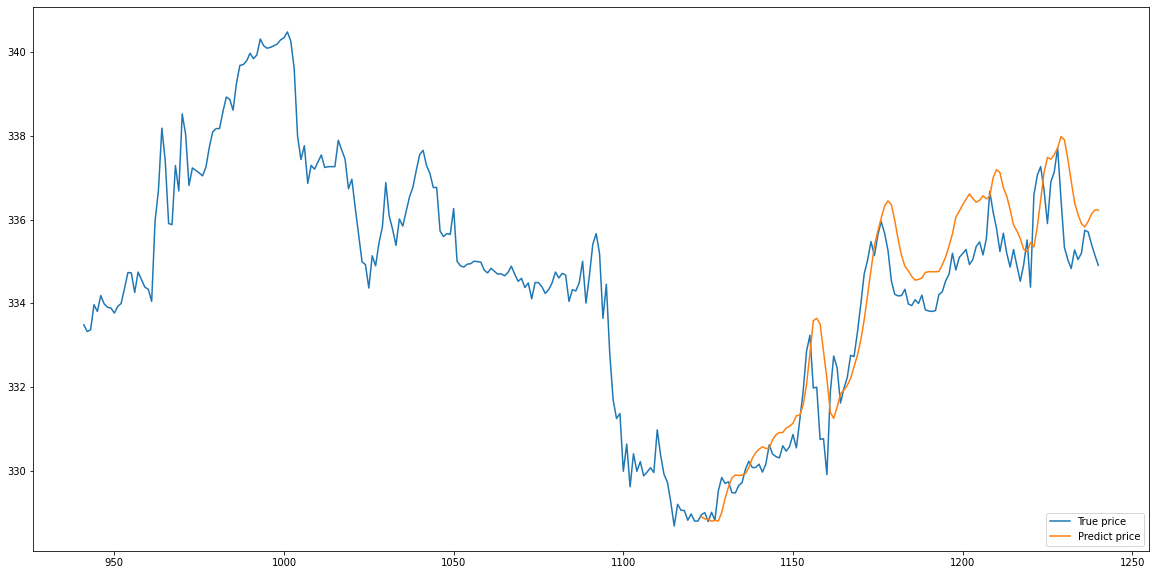

In [33]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
30/30 [==============================] - 2s 32ms/step - loss: 0.0436 - val_loss: 0.0130
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


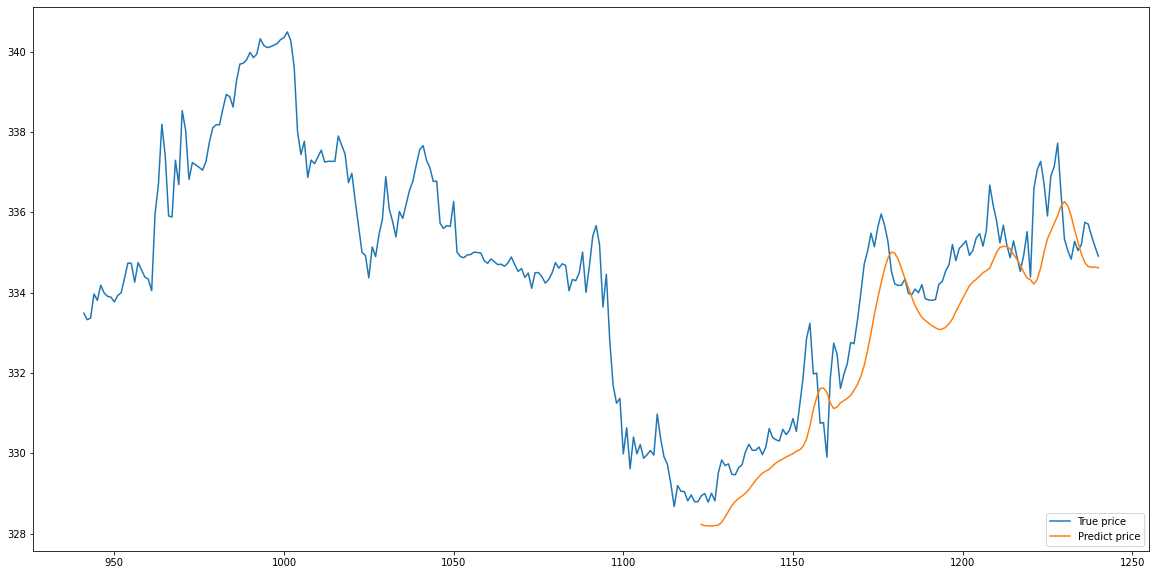

In [34]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0183 - val_loss: 0.0044
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 9.4457e-04
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0010 - val_loss: 8.6260e-04
Epoch 9/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 8.2261e-04
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 7.19

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


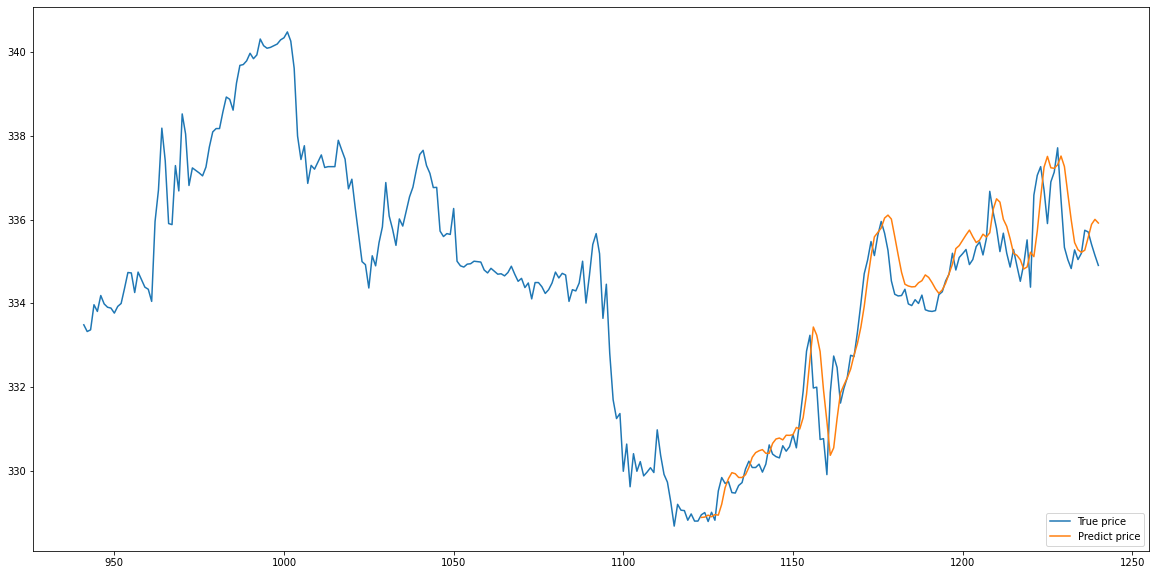

In [35]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
30/30 [==============================] - 3s 31ms/step - loss: 0.0175 - val_loss: 0.0026
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 9/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


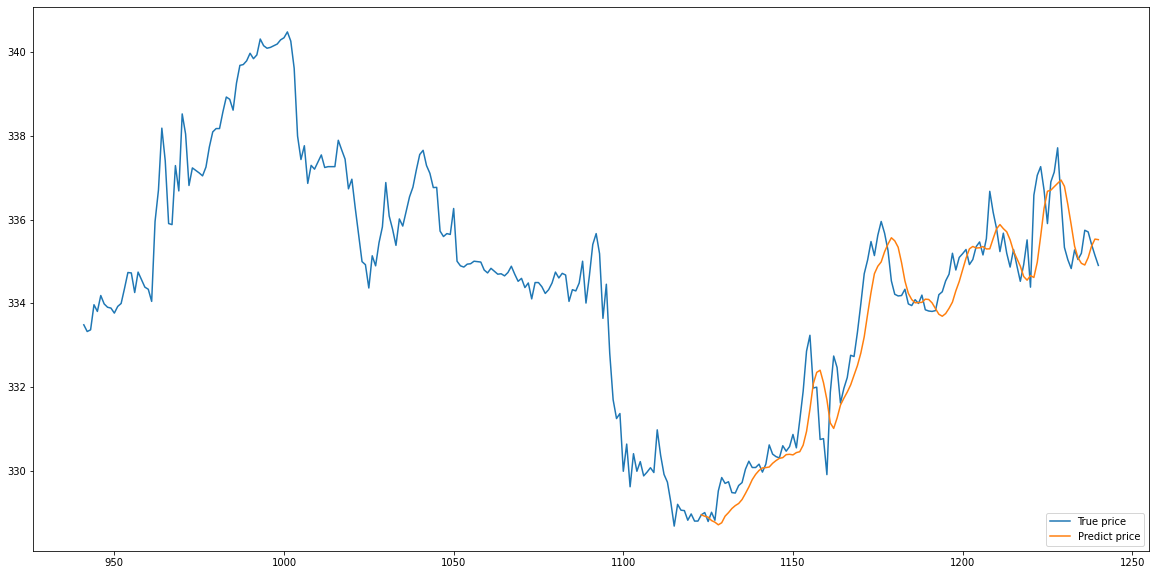

In [36]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.0270 - val_loss: 0.0026
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


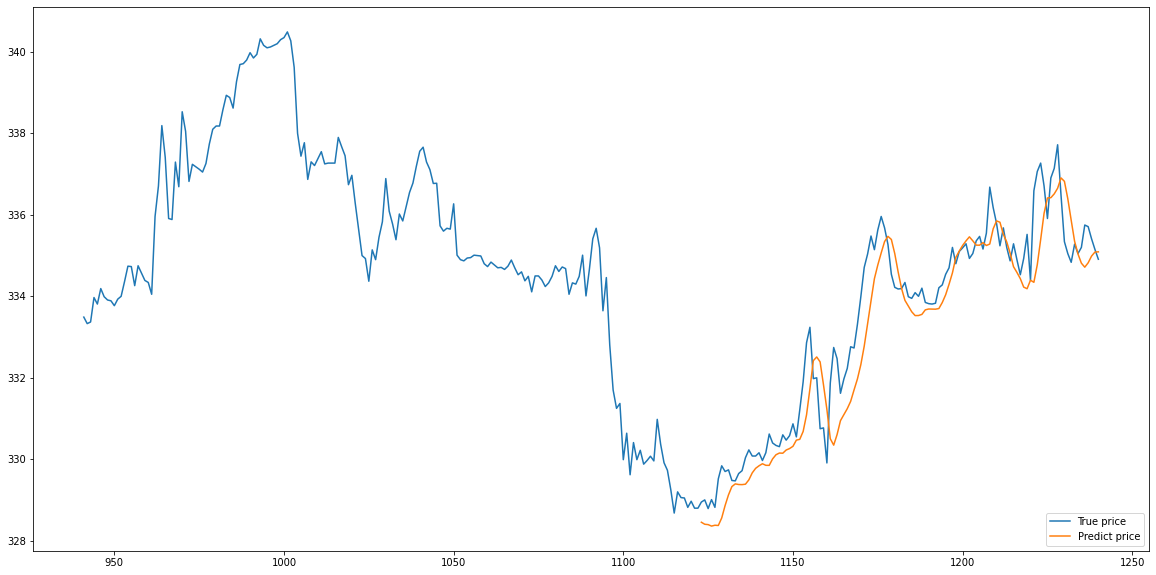

In [37]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.0180 - val_loss: 0.0021
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 9.7237e-04
Epoch

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


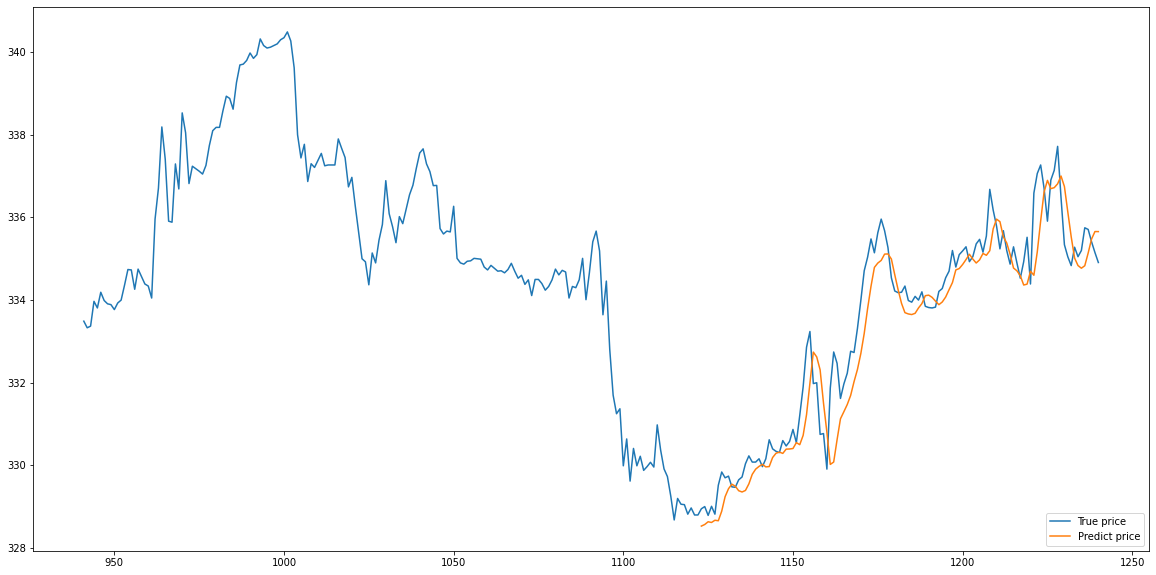

In [38]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0283 - val_loss: 0.0055
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


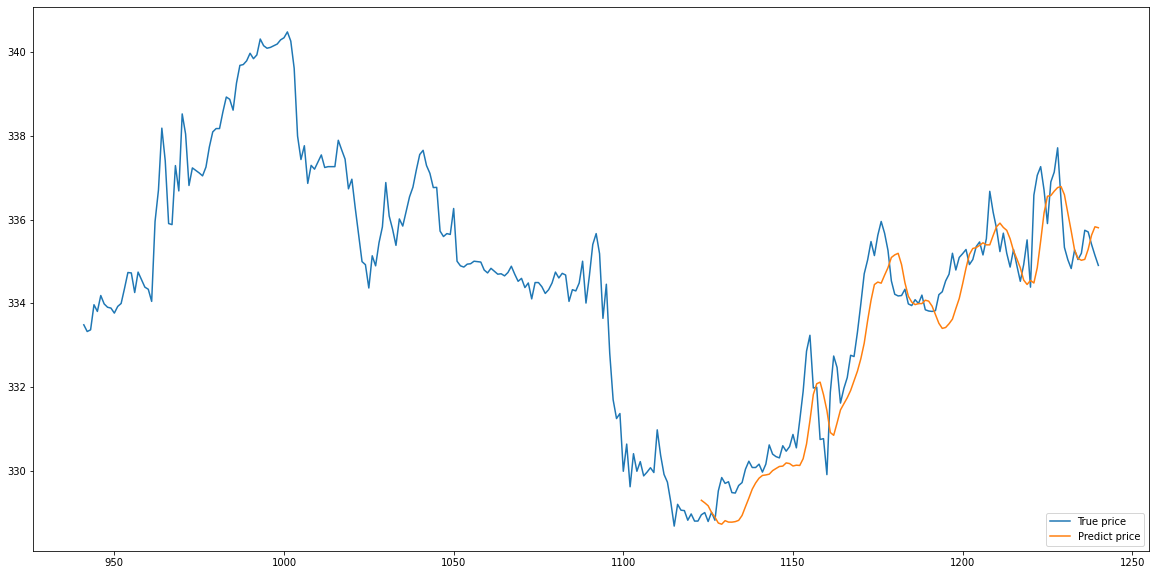

In [39]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0169 - val_loss: 0.0019
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


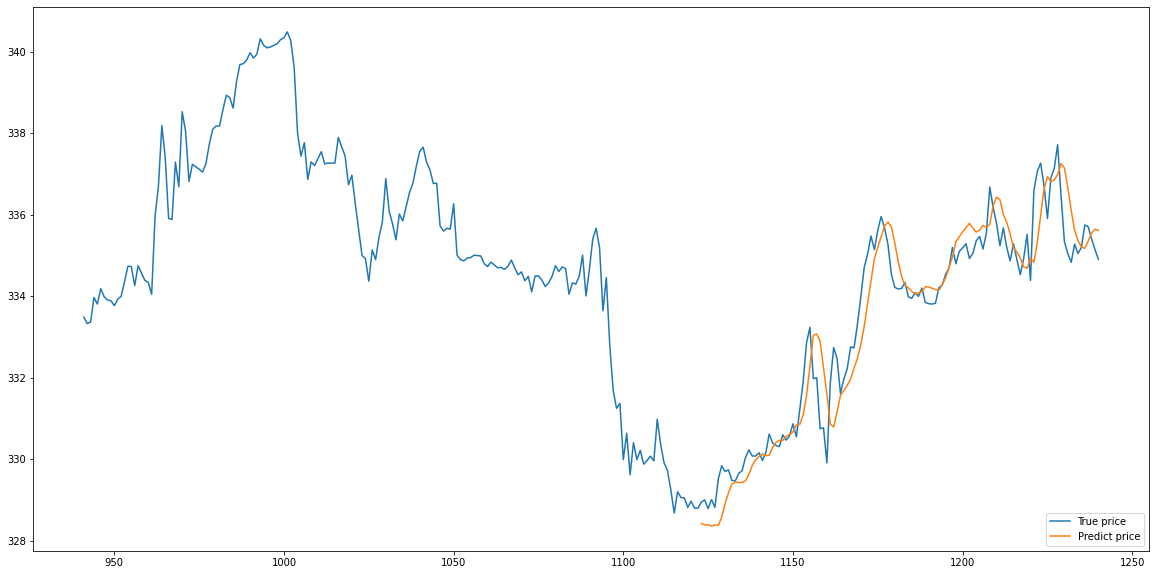

In [40]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
30/30 [==============================] - 2s 30ms/step - loss: 0.0516 - val_loss: 0.0143
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


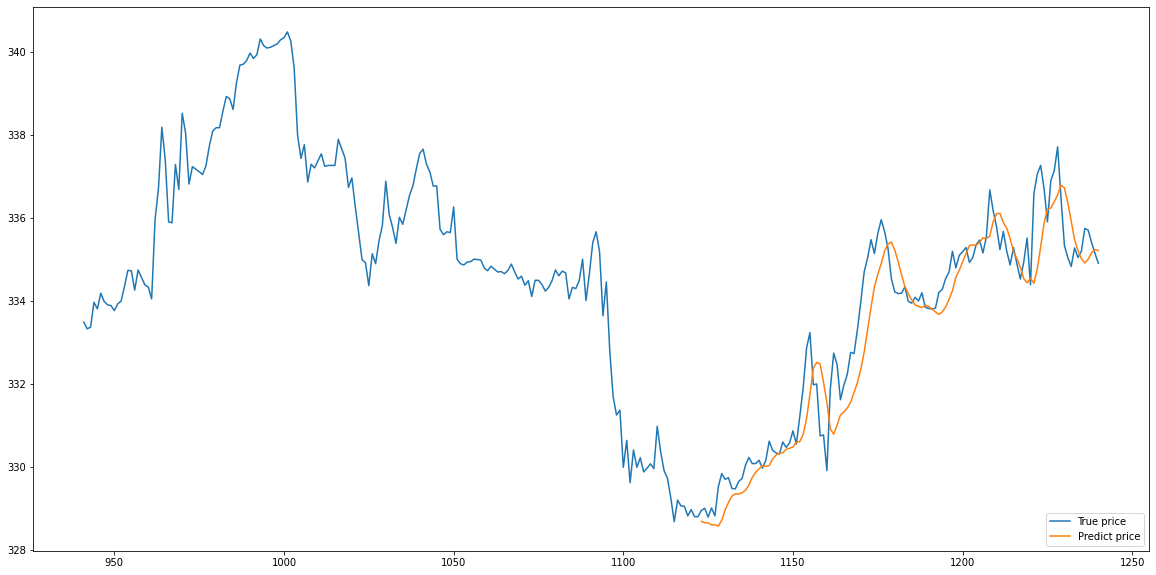

In [41]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
30/30 [==============================] - 2s 31ms/step - loss: 0.0373 - val_loss: 0.0090
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


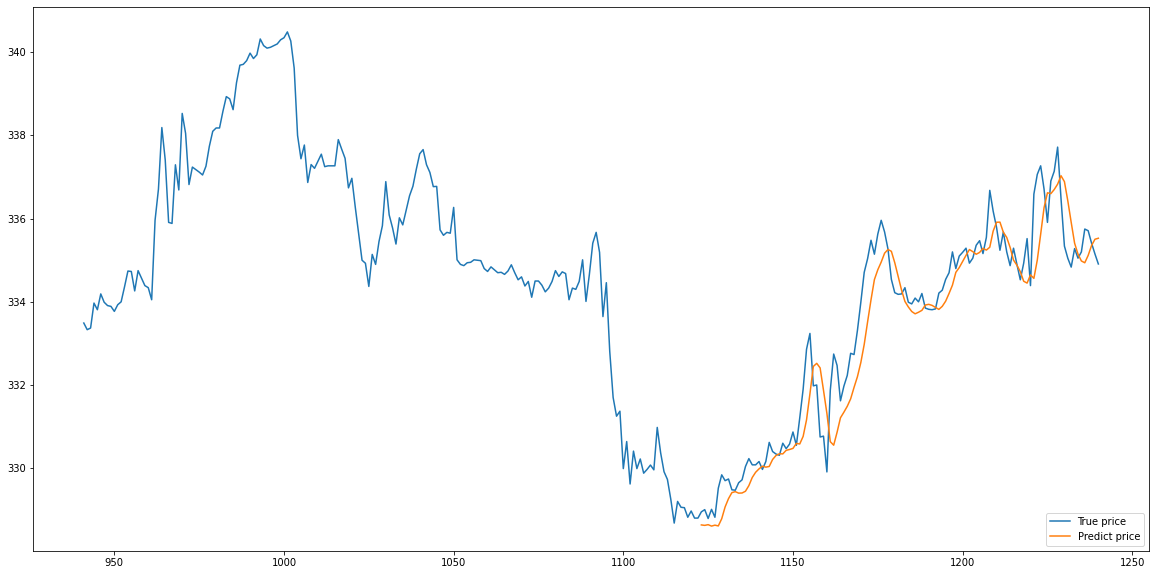

In [42]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [43]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [44]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[332.67 ],
       [332.29 ],
       [334.59 ],
       ...,
       [335.411],
       [335.15 ],
       [334.91 ]])

In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.36955064],
       [0.35680751],
       [0.43393696],
       ...,
       [0.46146881],
       [0.4527163 ],
       [0.44466801]])

In [46]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1181
1181


In [47]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (945, 60, 1)
Size validate:  (118, 60, 1)
Size test:  (118, 60, 1)


### b. Train Model

In [48]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
30/30 [==============================] - 4s 57ms/step - loss: 0.0435 - val_loss: 0.0030
Epoch 2/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0114 - val_loss: 0.0060
Epoch 3/25
30/30 [==============================] - 1s 41ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 4/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 5/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 6/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 8/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 9/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 10/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 11/

### c. Test Model

In [49]:
model_rnn = load_model('./MODEL/RNN.h5')

In [50]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [51]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open    high     low    close    volume     ROC  \
1123  2023-06-26 17:45:00  328.80  329.19  328.61  328.950    1455.0 -0.4419   
1124  2023-06-26 18:00:00  329.19  329.42  328.79  329.003    3559.0 -0.2991   
1125  2023-06-26 18:15:00  329.13  329.29  328.79  328.790    2136.0 -0.4333   
1126  2023-06-26 18:30:00  328.90  329.05  328.79  329.010    1509.0 -0.2637   
1127  2023-06-26 18:45:00  329.00  329.29  328.81  328.820     954.0 -0.3485   
...                   ...     ...     ...     ...      ...       ...     ...   
1236  2023-06-28 14:00:00  335.29  335.97  335.08  335.750  433864.0  0.2538   
1237  2023-06-28 14:15:00  335.74  336.18  335.67  335.710  413379.0  0.3527   
1238  2023-06-28 14:30:00  335.68  335.89  335.08  335.411  365289.0  0.1436   
1239  2023-06-28 14:45:00  335.39  335.47  335.00  335.150  334694.0 -0.1103   
1240  2023-06-28 15:00:00  335.19  335.22  333.81  334.910  628109.0  0.1555   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1123  329.5335  36.6679          329.5335       328.604611       330.462389   
1124  329.4842  37.1343          329.4842       328.521674       330.446726   
1125  329.4126  36.0125          329.4126       328.422429       330.402771   
1126  329.3691  38.0473          329.3691       328.419998       330.318202   
1127  329.3116  36.9783          329.3116       328.430008       330.193192   
...        ...      ...               ...              ...              ...   
1236  335.8830  51.5569          335.8830       332.923870       338.842130   
1237  335.9420  51.3458          335.9420       332.912704       338.971296   
1238  335.9661  49.7436          335.9661       332.882151       339.050049   
1239  335.9476  48.3571          335.9476       332.826285       339.068915   
1240  335.9736  47.0868          335.9736       332.861597       339.085603   

      predictions  
1123   329.219696  
1124   329.107910  
1125   329.020111  
1126   328.956055  
1127   328.915924  
...           ...  
1236   335.808960  
1237   335.529388  
1238   335.296906  
1239   335.124359  
1240   335.006744  

[118 rows x 13 columns]

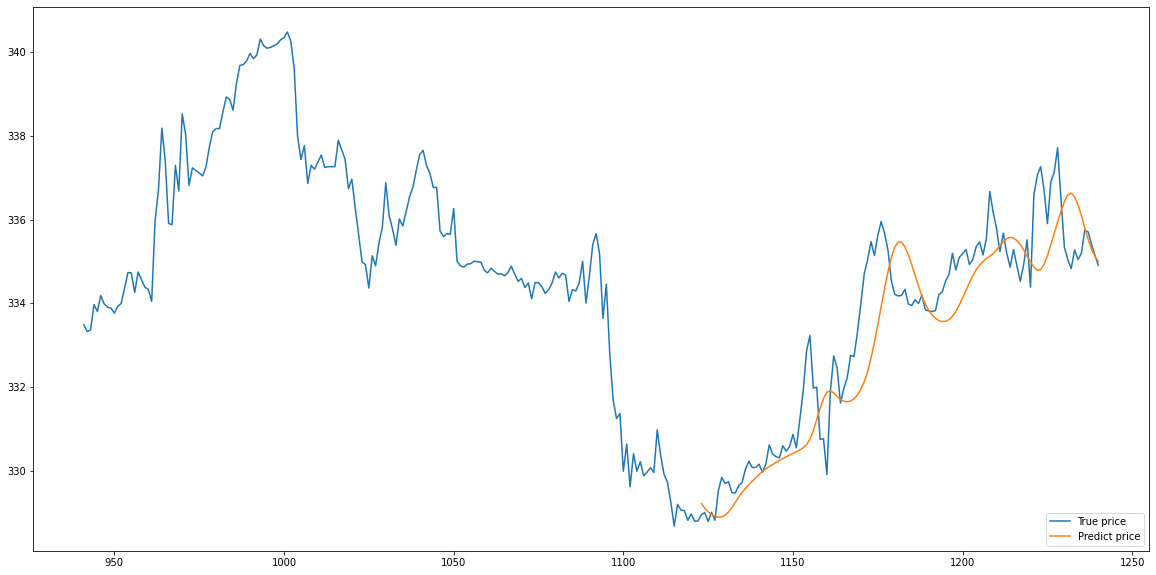

In [52]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [53]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.32670e+02,  1.62600e-01],
       [ 3.32290e+02, -8.72000e-02],
       [ 3.34590e+02,  8.40900e-01],
       ...,
       [ 3.35411e+02,  1.43600e-01],
       [ 3.35150e+02, -1.10300e-01],
       [ 3.34910e+02,  1.55500e-01]])

In [54]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.36955064, 0.50238509],
       [0.35680751, 0.46253251],
       [0.43393696, 0.6105997 ],
       ...,
       [0.46146881, 0.49935387],
       [0.4527163 , 0.45884718],
       [0.44466801, 0.50125237]])

In [55]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1181
1181


In [56]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (945, 60, 2)
Size validate:  (118, 60, 2)
Size test:  (118, 60, 2)


In [57]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
30/30 [==============================] - 4s 56ms/step - loss: 0.0404 - val_loss: 0.0026
Epoch 2/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0093 - val_loss: 0.0038
Epoch 3/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 5/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 6/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 8/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 9/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 10/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 11/

In [58]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [59]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

In [60]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open    high     low    close    volume     ROC  \
1123  2023-06-26 17:45:00  328.80  329.19  328.61  328.950    1455.0 -0.4419   
1124  2023-06-26 18:00:00  329.19  329.42  328.79  329.003    3559.0 -0.2991   
1125  2023-06-26 18:15:00  329.13  329.29  328.79  328.790    2136.0 -0.4333   
1126  2023-06-26 18:30:00  328.90  329.05  328.79  329.010    1509.0 -0.2637   
1127  2023-06-26 18:45:00  329.00  329.29  328.81  328.820     954.0 -0.3485   
...                   ...     ...     ...     ...      ...       ...     ...   
1236  2023-06-28 14:00:00  335.29  335.97  335.08  335.750  433864.0  0.2538   
1237  2023-06-28 14:15:00  335.74  336.18  335.67  335.710  413379.0  0.3527   
1238  2023-06-28 14:30:00  335.68  335.89  335.08  335.411  365289.0  0.1436   
1239  2023-06-28 14:45:00  335.39  335.47  335.00  335.150  334694.0 -0.1103   
1240  2023-06-28 15:00:00  335.19  335.22  333.81  334.910  628109.0  0.1555   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1123  329.5335  36.6679          329.5335       328.604611       330.462389   
1124  329.4842  37.1343          329.4842       328.521674       330.446726   
1125  329.4126  36.0125          329.4126       328.422429       330.402771   
1126  329.3691  38.0473          329.3691       328.419998       330.318202   
1127  329.3116  36.9783          329.3116       328.430008       330.193192   
...        ...      ...               ...              ...              ...   
1236  335.8830  51.5569          335.8830       332.923870       338.842130   
1237  335.9420  51.3458          335.9420       332.912704       338.971296   
1238  335.9661  49.7436          335.9661       332.882151       339.050049   
1239  335.9476  48.3571          335.9476       332.826285       339.068915   
1240  335.9736  47.0868          335.9736       332.861597       339.085603   

      predictions  
1123   328.553986  
1124   328.559082  
1125   328.561523  
1126   328.550079  
1127   328.524628  
...           ...  
1236   334.927429  
1237   334.716980  
1238   334.586456  
1239   334.530670  
1240   334.518219  

[118 rows x 13 columns]

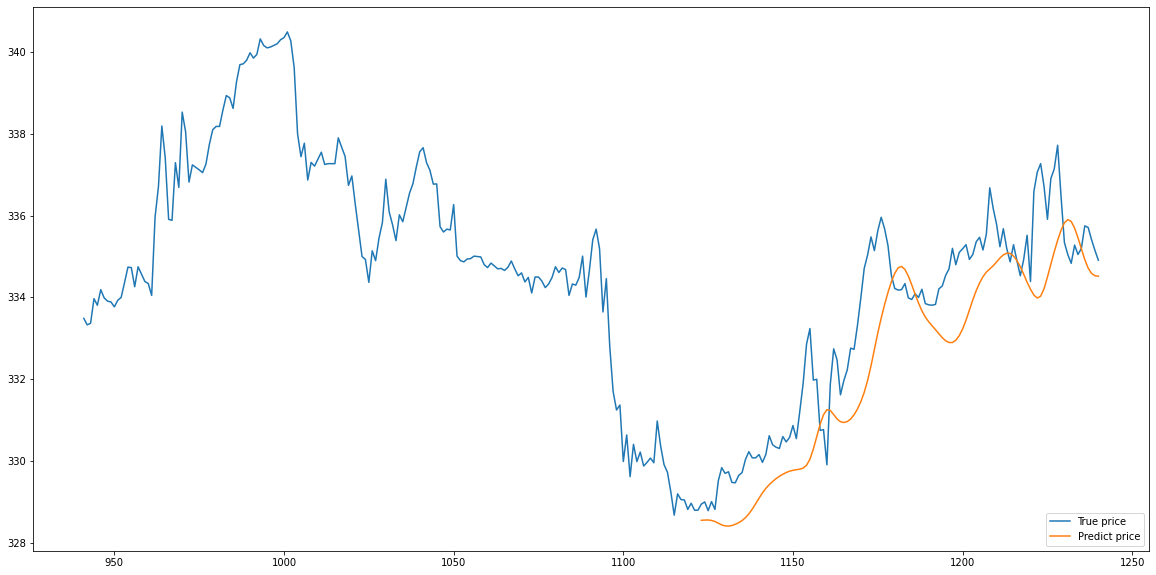

In [61]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
30/30 [==============================] - 4s 58ms/step - loss: 0.0366 - val_loss: 0.0029
Epoch 2/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0098 - val_loss: 0.0039
Epoch 3/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0063 - val_loss: 0.0039
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0061 - val_loss: 0.0035
Epoch 7/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 8/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 9/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 10/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


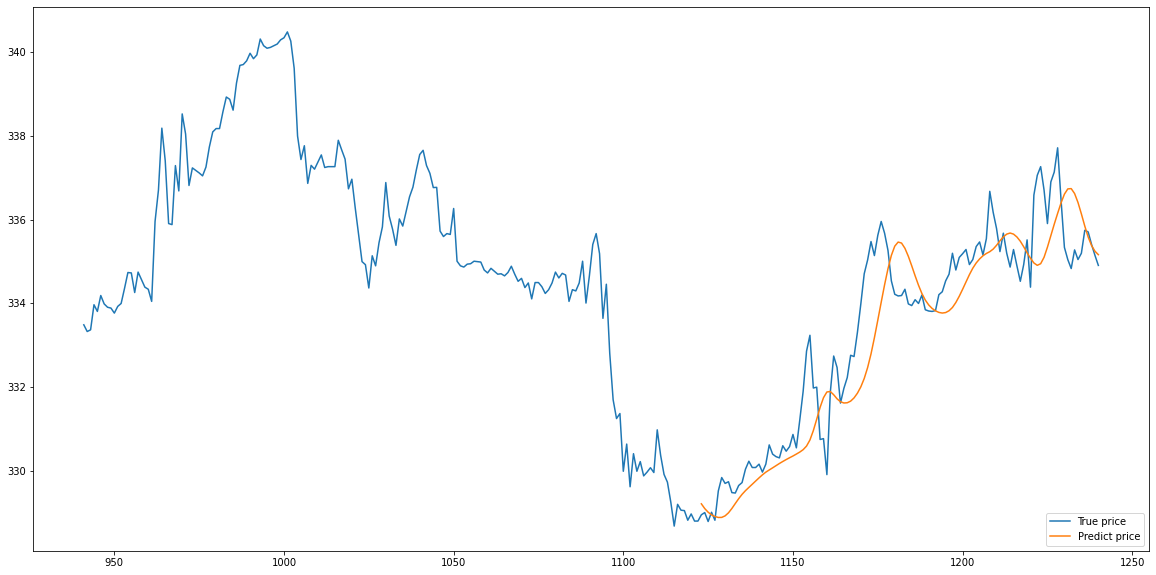

In [62]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
30/30 [==============================] - 4s 61ms/step - loss: 0.0411 - val_loss: 0.0037
Epoch 2/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0080 - val_loss: 0.0030
Epoch 3/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0065 - val_loss: 0.0030
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 5/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 6/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 8/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 9/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 10/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


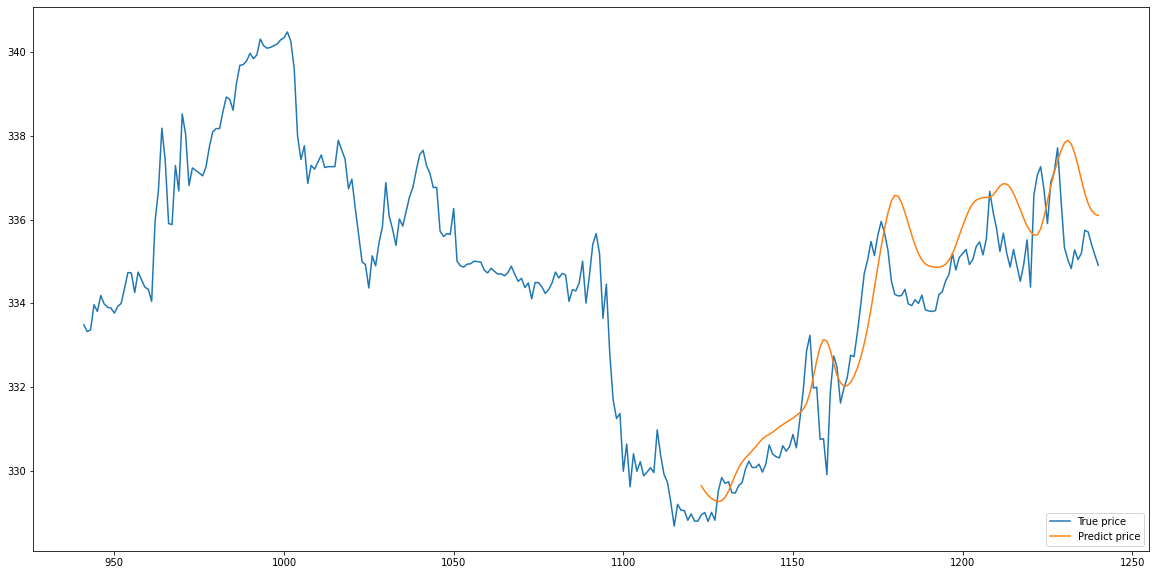

In [63]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
30/30 [==============================] - 4s 58ms/step - loss: 0.0290 - val_loss: 0.0108
Epoch 2/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0095 - val_loss: 0.0039
Epoch 3/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 4/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 5/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 6/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 7/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 8/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 9/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 10/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


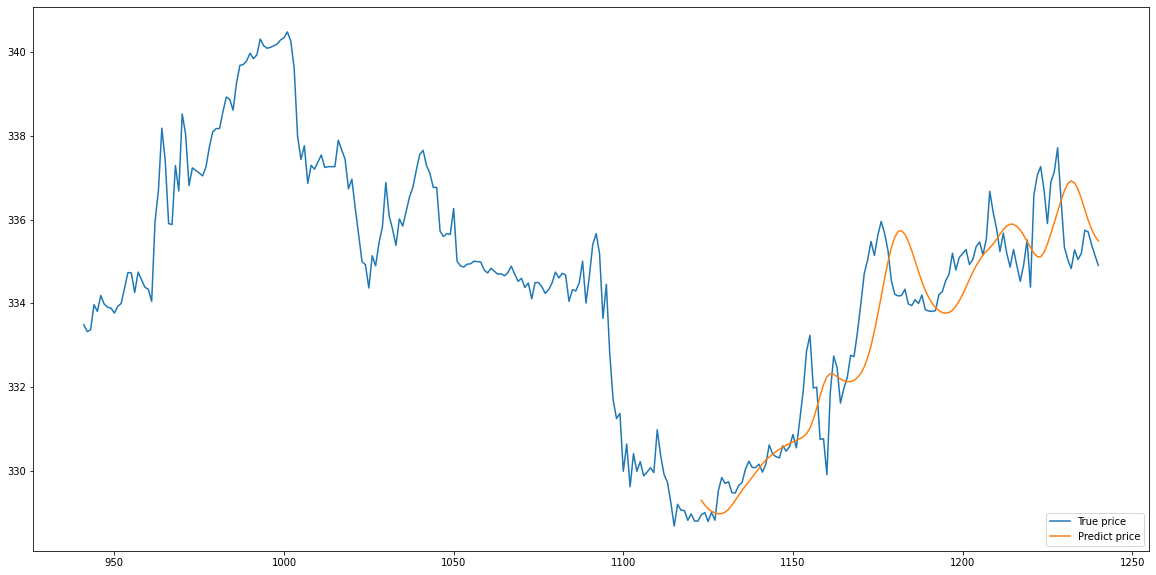

In [64]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
30/30 [==============================] - 4s 60ms/step - loss: 0.0369 - val_loss: 0.0036
Epoch 2/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0092 - val_loss: 0.0055
Epoch 3/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0073 - val_loss: 0.0034
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0076 - val_loss: 0.0028
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 8/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 9/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0052 - val_loss: 0.0092
Epoch 10/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


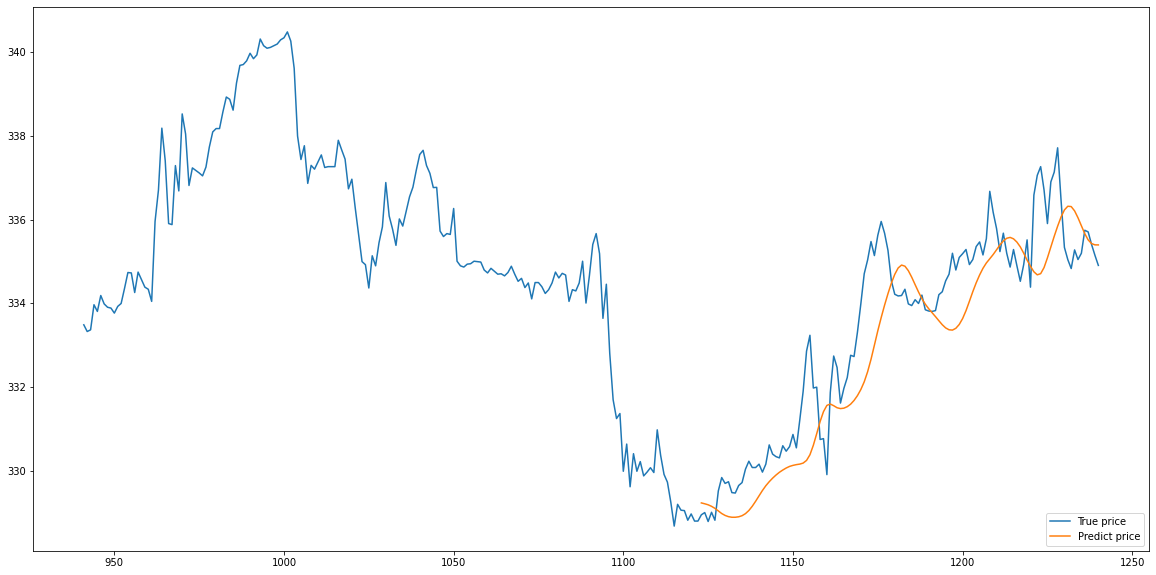

In [65]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
30/30 [==============================] - 4s 58ms/step - loss: 0.0259 - val_loss: 0.0048
Epoch 2/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0107 - val_loss: 0.0038
Epoch 3/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 6/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 8/25
30/30 [==============================] - 1s 36ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 9/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0055 - val_loss: 0.0025
Epoch 10/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


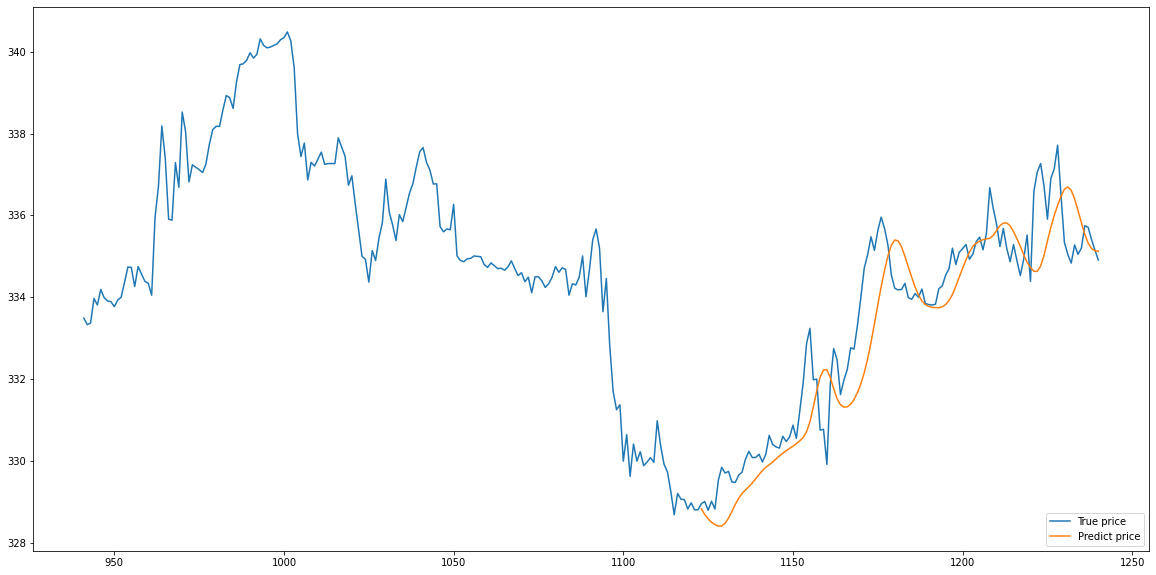

In [66]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
30/30 [==============================] - 4s 57ms/step - loss: 0.0437 - val_loss: 0.0031
Epoch 2/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0114 - val_loss: 0.0134
Epoch 3/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0086 - val_loss: 0.0041
Epoch 4/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0077 - val_loss: 0.0028
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 7/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 8/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 9/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 10/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0022
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


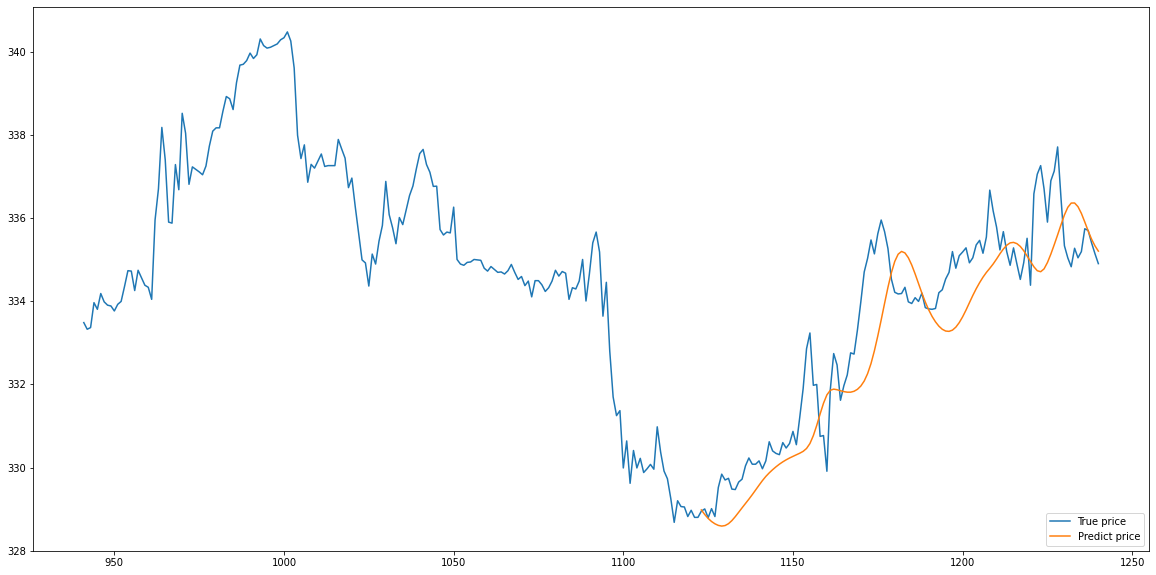

In [67]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
30/30 [==============================] - 4s 57ms/step - loss: 0.0483 - val_loss: 0.0025
Epoch 2/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0079 - val_loss: 0.0027
Epoch 3/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0058 - val_loss: 0.0028
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 7/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 8/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 9/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 10/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


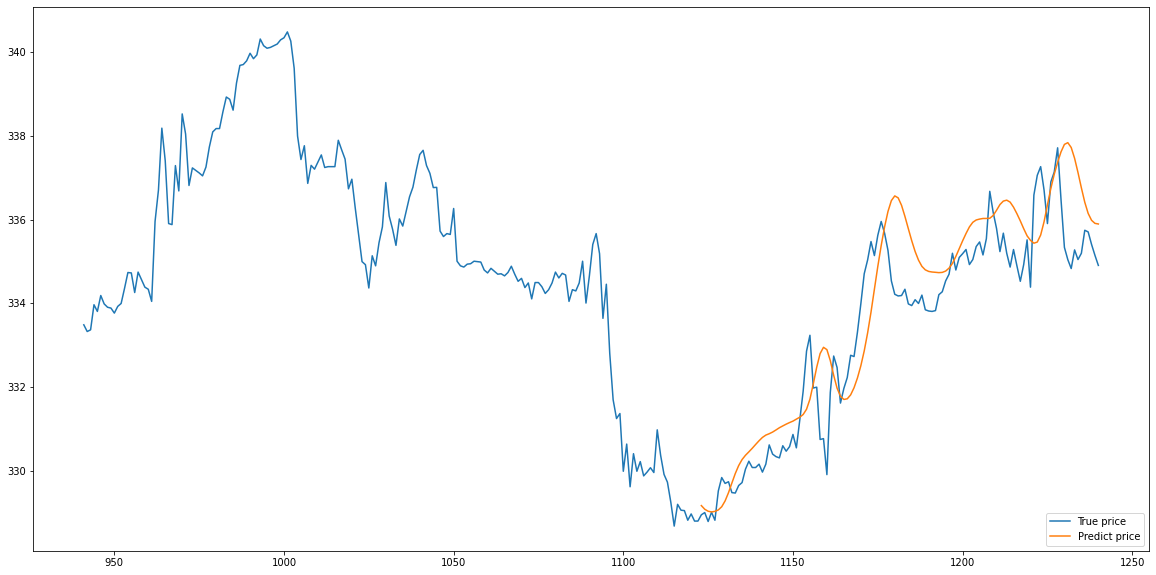

In [68]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
30/30 [==============================] - 4s 64ms/step - loss: 0.0331 - val_loss: 0.0072
Epoch 2/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 3/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 4/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 5/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 6/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 7/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 8/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 9/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 10/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


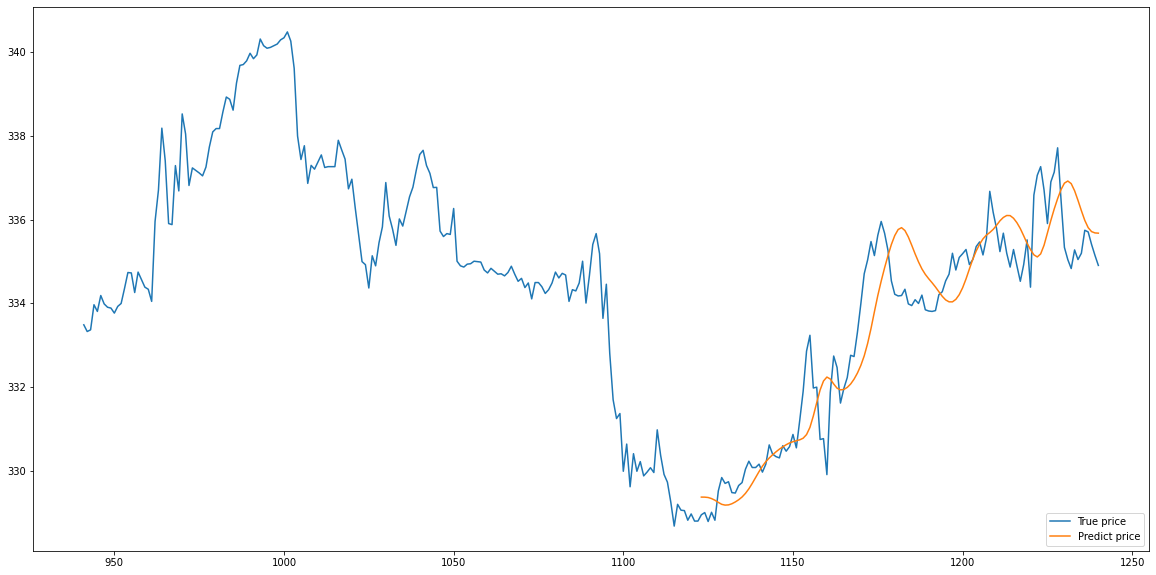

In [69]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
30/30 [==============================] - 4s 58ms/step - loss: 0.0330 - val_loss: 0.0038
Epoch 2/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0087 - val_loss: 0.0027
Epoch 3/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 5/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 8/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 9/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 10/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


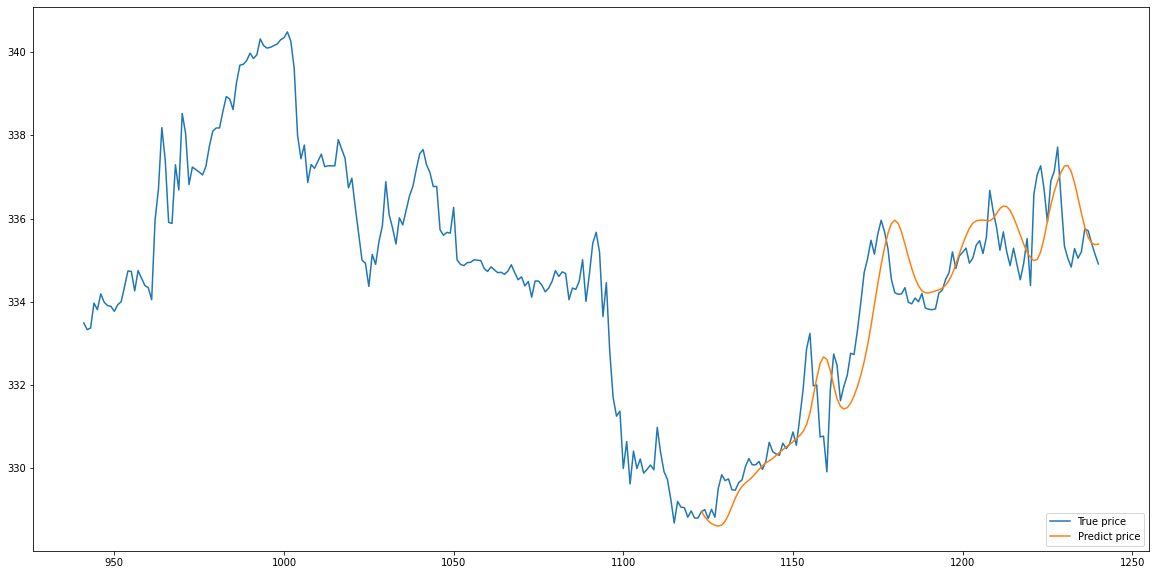

In [70]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
30/30 [==============================] - 4s 63ms/step - loss: 0.0346 - val_loss: 0.0089
Epoch 2/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 3/25
30/30 [==============================] - 1s 36ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 4/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 5/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 6/25
30/30 [==============================] - 1s 36ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 7/25
30/30 [==============================] - 1s 36ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 8/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 9/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 10/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


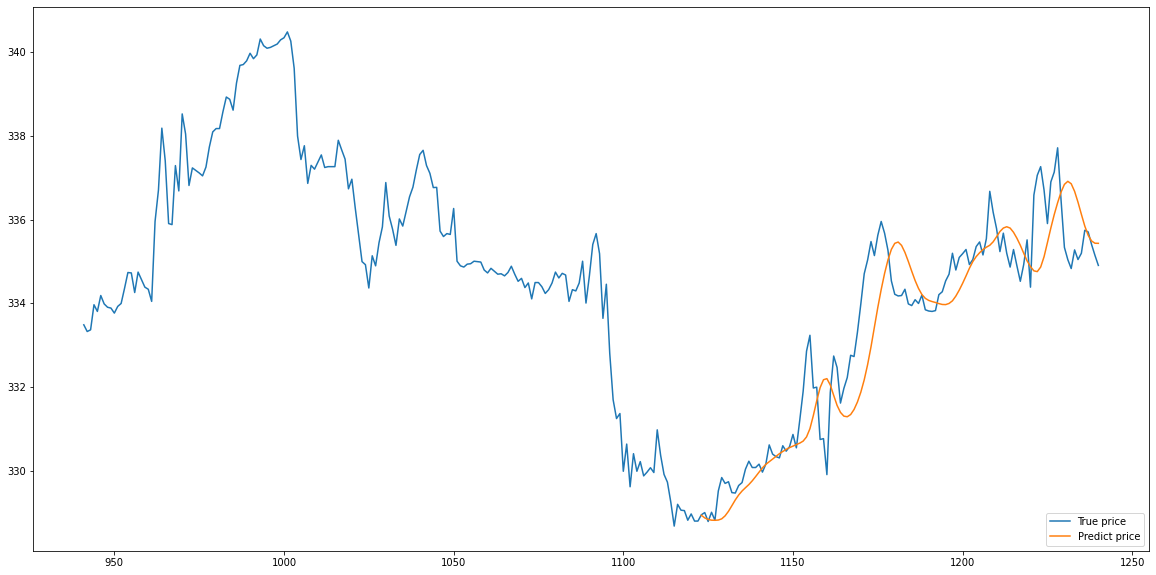

In [71]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
30/30 [==============================] - 4s 57ms/step - loss: 0.0289 - val_loss: 0.0072
Epoch 2/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 3/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0079 - val_loss: 0.0044
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0076 - val_loss: 0.0032
Epoch 5/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0066 - val_loss: 0.0030
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 7/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 8/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 9/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0058 - val_loss: 0.0096
Epoch 10/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


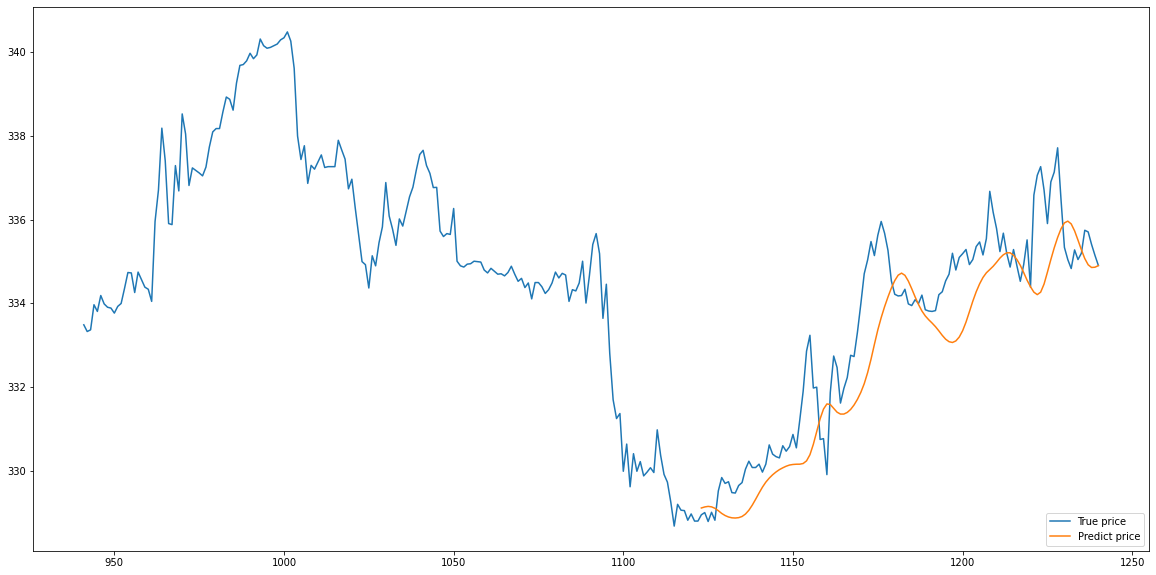

In [72]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
30/30 [==============================] - 4s 58ms/step - loss: 0.0310 - val_loss: 0.0083
Epoch 2/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0091 - val_loss: 0.0033
Epoch 3/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0064 - val_loss: 0.0088
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 6/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 7/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 8/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 9/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 10/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


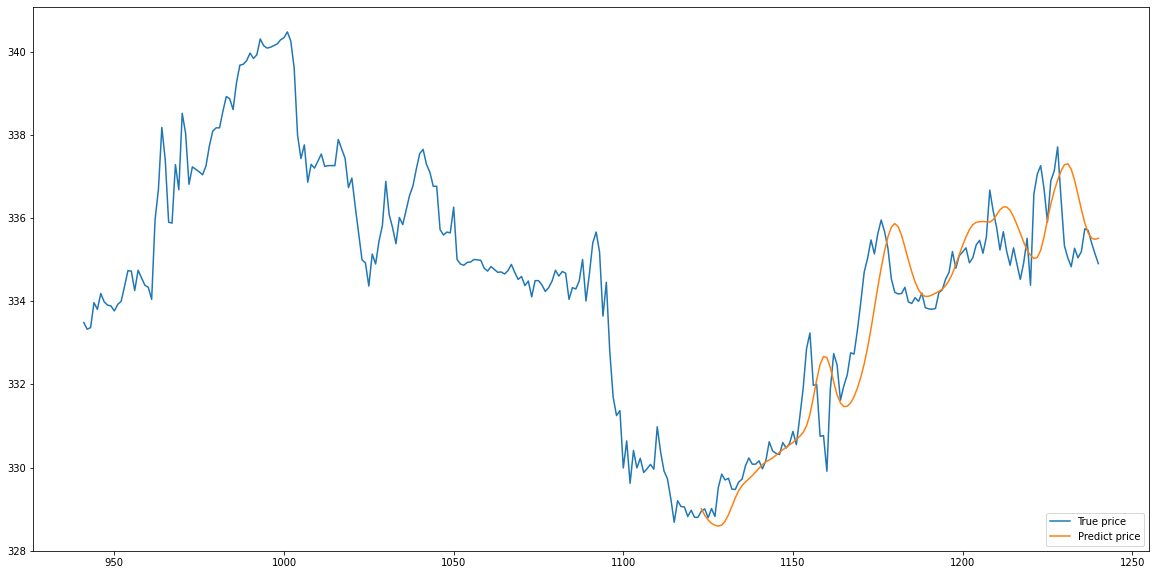

In [73]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
30/30 [==============================] - 4s 57ms/step - loss: 0.0404 - val_loss: 0.0105
Epoch 2/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0085 - val_loss: 0.0049
Epoch 3/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0075 - val_loss: 0.0030
Epoch 4/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0059 - val_loss: 0.0024
Epoch 6/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 7/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 8/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 9/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 10/25
30/30 [==============================] - 1s 39ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


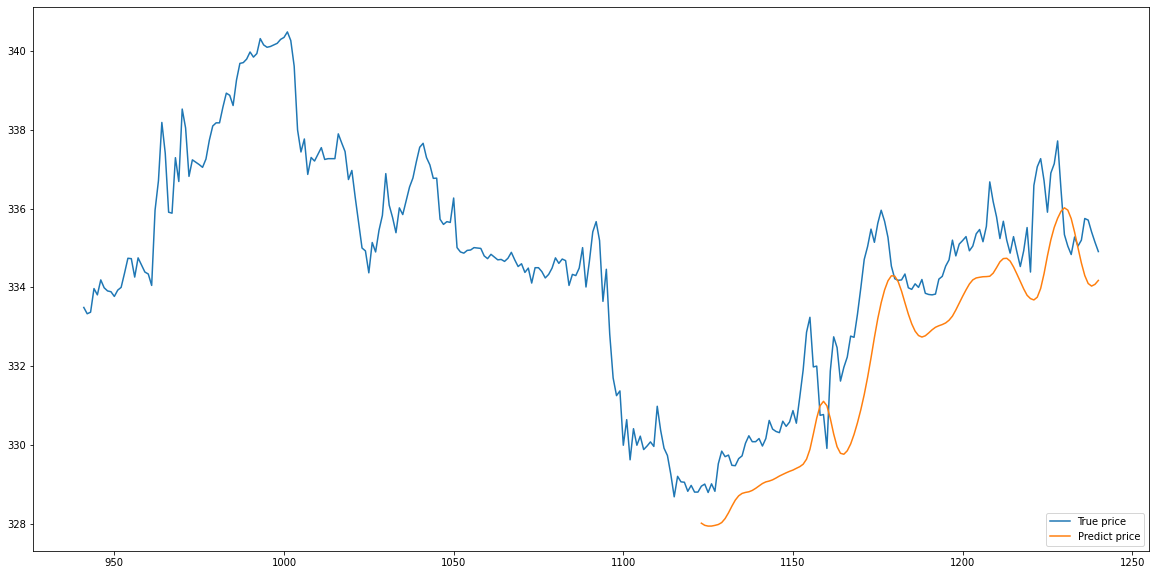

In [74]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
30/30 [==============================] - 4s 64ms/step - loss: 0.0295 - val_loss: 0.0123
Epoch 2/25
30/30 [==============================] - 1s 40ms/step - loss: 0.0102 - val_loss: 0.0045
Epoch 3/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 4/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 5/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 6/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 7/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 8/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 9/25
30/30 [==============================] - 1s 37ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 10/25
30/30 [==============================] - 1s 38ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


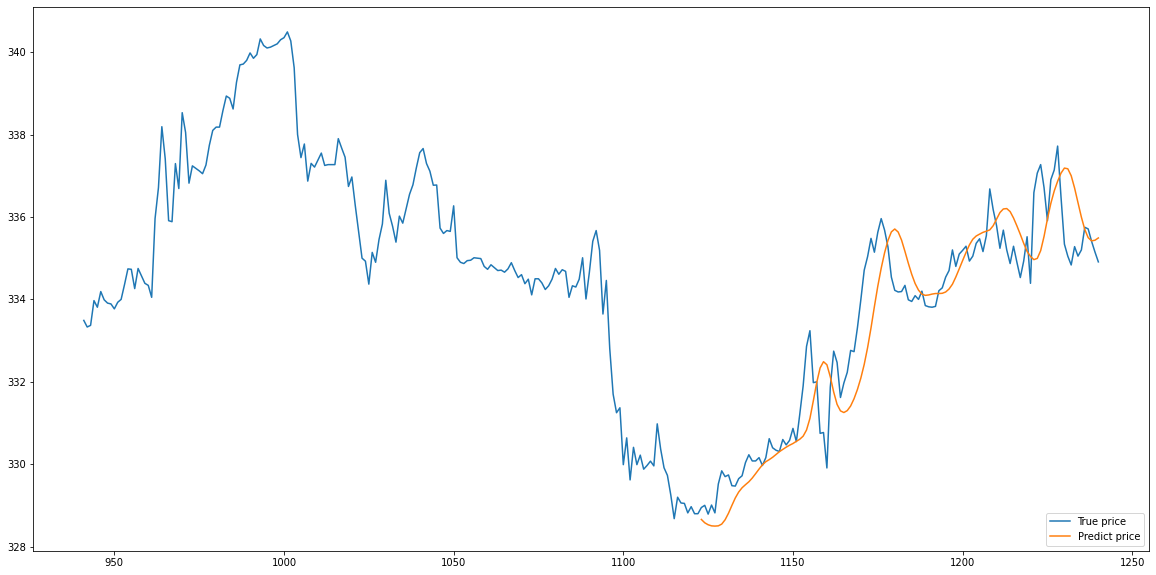

In [75]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [76]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

close     volume
0     332.670    38541.0
1     332.290    74220.0
2     334.590  2789882.0
3     334.710  1711224.0
4     332.710  1404624.0
...       ...        ...
1236  335.750   433864.0
1237  335.710   413379.0
1238  335.411   365289.0
1239  335.150   334694.0
1240  334.910   628109.0

[1241 rows x 2 columns]

In [77]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume  close_date_1  volume_date_1  close_date_2  \
0     332.670    38541.0           NaN            NaN           NaN   
1     332.290    74220.0       332.670        38541.0           NaN   
2     334.590  2789882.0       332.290        74220.0       332.670   
3     334.710  1711224.0       334.590      2789882.0       332.290   
4     332.710  1404624.0       334.710      1711224.0       334.590   
...       ...        ...           ...            ...           ...   
1236  335.750   433864.0       335.200       476077.0       335.050   
1237  335.710   413379.0       335.750       433864.0       335.200   
1238  335.411   365289.0       335.710       413379.0       335.750   
1239  335.150   334694.0       335.411       365289.0       335.710   
1240  334.910   628109.0       335.150       334694.0       335.411   

      volume_date_2  
0               NaN  
1               NaN  
2           38541.0  
3           74220.0  
4         2789882.0  
...             ...  
1236       561146.0  
1237       476077.0  
1238       433864.0  
1239       413379.0  
1240       365289.0  

[1241 rows x 6 columns]

In [78]:
dataset.dropna(inplace=True)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume  close_date_1  volume_date_1  close_date_2  \
2     334.590  2789882.0       332.290        74220.0       332.670   
3     334.710  1711224.0       334.590      2789882.0       332.290   
4     332.710  1404624.0       334.710      1711224.0       334.590   
5     331.751  1156766.0       332.710      1404624.0       334.710   
6     331.100   976777.0       331.751      1156766.0       332.710   
...       ...        ...           ...            ...           ...   
1236  335.750   433864.0       335.200       476077.0       335.050   
1237  335.710   413379.0       335.750       433864.0       335.200   
1238  335.411   365289.0       335.710       413379.0       335.750   
1239  335.150   334694.0       335.411       365289.0       335.710   
1240  334.910   628109.0       335.150       334694.0       335.411   

      volume_date_2  
2           38541.0  
3           74220.0  
4         2789882.0  
5         1711224.0  
6         1404624.0  
...             ...  
1236       561146.0  
1237       476077.0  
1238       433864.0  
1239       413379.0  
1240       365289.0  

[1239 rows x 6 columns]

In [79]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1239, 4)
(1239, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2          332.290        74220.0       332.670        38541.0
3          334.590      2789882.0       332.290        74220.0
4          334.710      1711224.0       334.590      2789882.0
5          332.710      1404624.0       334.710      1711224.0
6          331.751      1156766.0       332.710      1404624.0
...            ...            ...           ...            ...
1236       335.200       476077.0       335.050       561146.0
1237       335.750       433864.0       335.200       476077.0
1238       335.710       413379.0       335.750       433864.0
1239       335.411       365289.0       335.710       413379.0
1240       335.150       334694.0       335.411       365289.0

[1239 rows x 4 columns]

In [80]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1116, 4)
Size test:  (123, 4)


### b. Train Model

In [81]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [82]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [83]:
predictions = model_xgboost.predict(X_test)
predictions

array([329.24454, 328.97583, 329.5158 , 328.94205, 329.01163, 328.92282,
       328.86743, 328.92355, 328.98013, 328.9894 , 329.2082 , 328.95172,
       330.2043 , 329.09305, 328.74622, 328.84702, 328.91806, 328.92172,
       328.9133 , 330.17014, 330.16098, 330.16098, 330.16098, 330.16098,
       330.10037, 330.0916 , 330.24878, 329.96054, 330.041  , 329.9395 ,
       330.3478 , 330.58426, 330.42548, 331.84784, 330.7083 , 331.9203 ,
       332.10974, 332.8761 , 333.50555, 331.5551 , 332.09497, 330.8787 ,
       330.17767, 330.32965, 331.41345, 332.92163, 332.68967, 331.99146,
       331.74243, 331.96024, 332.90152, 332.97726, 333.24997, 333.85852,
       334.5678 , 334.48434, 334.6092 , 335.43417, 334.78928, 335.7591 ,
       335.434  , 335.61404, 334.90494, 333.9973 , 334.37476, 334.43423,
       334.70184, 334.1427 , 333.9845 , 334.42236, 334.232  , 334.29773,
       333.8113 , 333.94687, 333.9209 , 333.9375 , 334.34665, 334.3826 ,
       334.618  , 334.6881 , 335.01532, 334.54477, 

In [84]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close    volume  close_date_1  volume_date_1  close_date_2  \
1118  329.050    8644.0       329.060        14678.0       329.200   
1119  328.820  196679.0       329.050         8644.0       329.060   
1120  328.970    8701.0       328.820       196679.0       329.050   
1121  328.800    2506.0       328.970         8701.0       328.820   
1122  328.800    5631.0       328.800         2506.0       328.970   
...       ...       ...           ...            ...           ...   
1236  335.750  433864.0       335.200       476077.0       335.050   
1237  335.710  413379.0       335.750       433864.0       335.200   
1238  335.411  365289.0       335.710       413379.0       335.750   
1239  335.150  334694.0       335.411       365289.0       335.710   
1240  334.910  628109.0       335.150       334694.0       335.411   

      volume_date_2  predictions  
1118      6937933.0   329.244537  
1119        14678.0   328.975830  
1120         8644.0   329.515808  
1121       196679.0   328.942047  
1122         8701.0   329.011627  
...             ...          ...  
1236       561146.0   334.805878  
1237       476077.0   335.040344  
1238       433864.0   335.717804  
1239       413379.0   335.541443  
1240       365289.0   335.810791  

[123 rows x 7 columns]

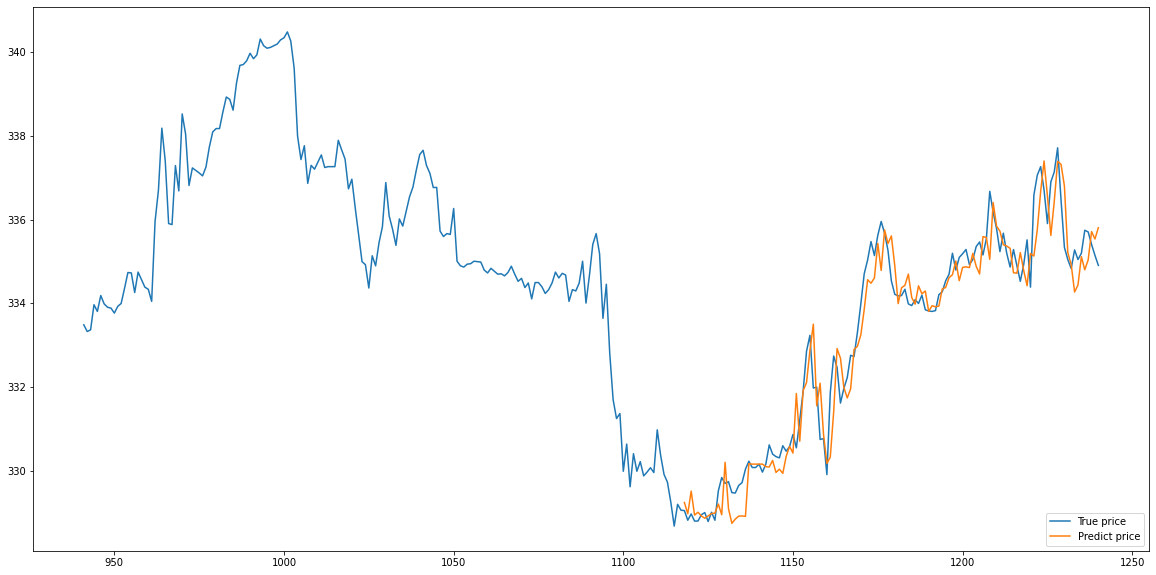

In [85]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [86]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close     volume     ROC
0     332.670    38541.0  0.1626
1     332.290    74220.0 -0.0872
2     334.590  2789882.0  0.8409
3     334.710  1711224.0  0.7465
4     332.710  1404624.0  0.0150
...       ...        ...     ...
1236  335.750   433864.0  0.2538
1237  335.710   413379.0  0.3527
1238  335.411   365289.0  0.1436
1239  335.150   334694.0 -0.1103
1240  334.910   628109.0  0.1555

[1241 rows x 3 columns]

In [87]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
0     332.670    38541.0  0.1626           NaN            NaN         NaN   
1     332.290    74220.0 -0.0872       332.670        38541.0      0.1626   
2     334.590  2789882.0  0.8409       332.290        74220.0     -0.0872   
3     334.710  1711224.0  0.7465       334.590      2789882.0      0.8409   
4     332.710  1404624.0  0.0150       334.710      1711224.0      0.7465   
...       ...        ...     ...           ...            ...         ...   
1236  335.750   433864.0  0.2538       335.200       476077.0     -0.0265   
1237  335.710   413379.0  0.3527       335.750       433864.0      0.2538   
1238  335.411   365289.0  0.1436       335.710       413379.0      0.3527   
1239  335.150   334694.0 -0.1103       335.411       365289.0      0.1436   
1240  334.910   628109.0  0.1555       335.150       334694.0     -0.1103   

      close_date_2  volume_date_2  ROC_date_2  
0              NaN            NaN         NaN  
1              NaN            NaN         NaN  
2          332.670        38541.0      0.1626  
3          332.290        74220.0     -0.0872  
4          334.590      2789882.0      0.8409  
...            ...            ...         ...  
1236       335.050       561146.0      0.0538  
1237       335.200       476077.0     -0.0265  
1238       335.750       433864.0      0.2538  
1239       335.710       413379.0      0.3527  
1240       335.411       365289.0      0.1436  

[1241 rows x 9 columns]

In [88]:
dataset.dropna(inplace=True)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
2     334.590  2789882.0  0.8409       332.290        74220.0     -0.0872   
3     334.710  1711224.0  0.7465       334.590      2789882.0      0.8409   
4     332.710  1404624.0  0.0150       334.710      1711224.0      0.7465   
5     331.751  1156766.0 -0.1742       332.710      1404624.0      0.0150   
6     331.100   976777.0 -0.5108       331.751      1156766.0     -0.1742   
...       ...        ...     ...           ...            ...         ...   
1236  335.750   433864.0  0.2538       335.200       476077.0     -0.0265   
1237  335.710   413379.0  0.3527       335.750       433864.0      0.2538   
1238  335.411   365289.0  0.1436       335.710       413379.0      0.3527   
1239  335.150   334694.0 -0.1103       335.411       365289.0      0.1436   
1240  334.910   628109.0  0.1555       335.150       334694.0     -0.1103   

      close_date_2  volume_date_2  ROC_date_2  
2          332.670        38541.0      0.1626  
3          332.290        74220.0     -0.0872  
4          334.590      2789882.0      0.8409  
5          334.710      1711224.0      0.7465  
6          332.710      1404624.0      0.0150  
...            ...            ...         ...  
1236       335.050       561146.0      0.0538  
1237       335.200       476077.0     -0.0265  
1238       335.750       433864.0      0.2538  
1239       335.710       413379.0      0.3527  
1240       335.411       365289.0      0.1436  

[1239 rows x 9 columns]

In [89]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1239, 6)
(1239, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2          332.290        74220.0     -0.0872       332.670        38541.0   
3          334.590      2789882.0      0.8409       332.290        74220.0   
4          334.710      1711224.0      0.7465       334.590      2789882.0   
5          332.710      1404624.0      0.0150       334.710      1711224.0   
6          331.751      1156766.0     -0.1742       332.710      1404624.0   
...            ...            ...         ...           ...            ...   
1236       335.200       476077.0     -0.0265       335.050       561146.0   
1237       335.750       433864.0      0.2538       335.200       476077.0   
1238       335.710       413379.0      0.3527       335.750       433864.0   
1239       335.411       365289.0      0.1436       335.710       413379.0   
1240       335.150       334694.0     -0.1103       335.411       365289.0   

      ROC_date_2  
2         0.1626  
3        -0.0872  
4         0.8409  
5         0.7465  
6         0.0150  
...          ...  
1236      0.0538  
1237     -0.0265  
1238      0.2538  
1239      0.3527  
1240      0.1436  

[1239 rows x 6 columns]

In [90]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1116, 6)
Size test:  (123, 6)


In [91]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [92]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [93]:
predictions = model_xgboost.predict(X_test)
predictions

array([329.32666, 328.55817, 328.97574, 328.7379 , 328.94357, 328.9355 ,
       328.98807, 328.75745, 328.78763, 328.91028, 329.035  , 329.10956,
       330.256  , 328.98447, 328.78018, 328.77222, 328.9374 , 328.91107,
       328.83875, 330.30676, 330.26843, 330.3745 , 330.28857, 330.2831 ,
       330.26703, 329.99554, 330.66147, 330.06955, 330.30978, 330.20108,
       330.56097, 330.63907, 330.53702, 331.68912, 330.84586, 331.6763 ,
       332.2767 , 332.9506 , 333.5957 , 331.5909 , 332.13965, 330.6617 ,
       330.54803, 330.2446 , 331.45053, 333.2391 , 332.8449 , 332.17648,
       331.97064, 332.23053, 333.0323 , 333.12296, 333.59592, 334.1266 ,
       334.21515, 334.32648, 334.7596 , 335.19772, 334.93958, 335.61646,
       335.53574, 335.28485, 334.22617, 334.04544, 334.41275, 334.56735,
       334.69864, 334.46518, 334.12674, 334.1728 , 334.46158, 334.15494,
       333.76773, 333.87582, 333.8811 , 333.97736, 334.39053, 334.38788,
       334.75665, 334.72873, 334.87708, 334.45932, 

In [94]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close    volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
1118  329.050    8644.0 -0.6642       329.060        14678.0     -0.7959   
1119  328.820  196679.0 -0.7695       329.050         8644.0     -0.6642   
1120  328.970    8701.0 -0.3091       328.820       196679.0     -0.7695   
1121  328.800    2506.0 -0.5565       328.970         8701.0     -0.3091   
1122  328.800    5631.0 -0.2488       328.800         2506.0     -0.5565   
...       ...       ...     ...           ...            ...         ...   
1236  335.750  433864.0  0.2538       335.200       476077.0     -0.0265   
1237  335.710  413379.0  0.3527       335.750       433864.0      0.2538   
1238  335.411  365289.0  0.1436       335.710       413379.0      0.3527   
1239  335.150  334694.0 -0.1103       335.411       365289.0      0.1436   
1240  334.910  628109.0  0.1555       335.150       334694.0     -0.1103   

      close_date_2  volume_date_2  ROC_date_2  predictions  
1118       329.200      6937933.0     -1.0847   329.326660  
1119       329.060        14678.0     -0.7959   328.558167  
1120       329.050         8644.0     -0.6642   328.975739  
1121       328.820       196679.0     -0.7695   328.737915  
1122       328.970         8701.0     -0.3091   328.943573  
...            ...            ...         ...          ...  
1236       335.050       561146.0      0.0538   334.558197  
1237       335.200       476077.0     -0.0265   335.131012  
1238       335.750       433864.0      0.2538   335.837341  
1239       335.710       413379.0      0.3527   335.431183  
1240       335.411       365289.0      0.1436   335.481110  

[123 rows x 10 columns]

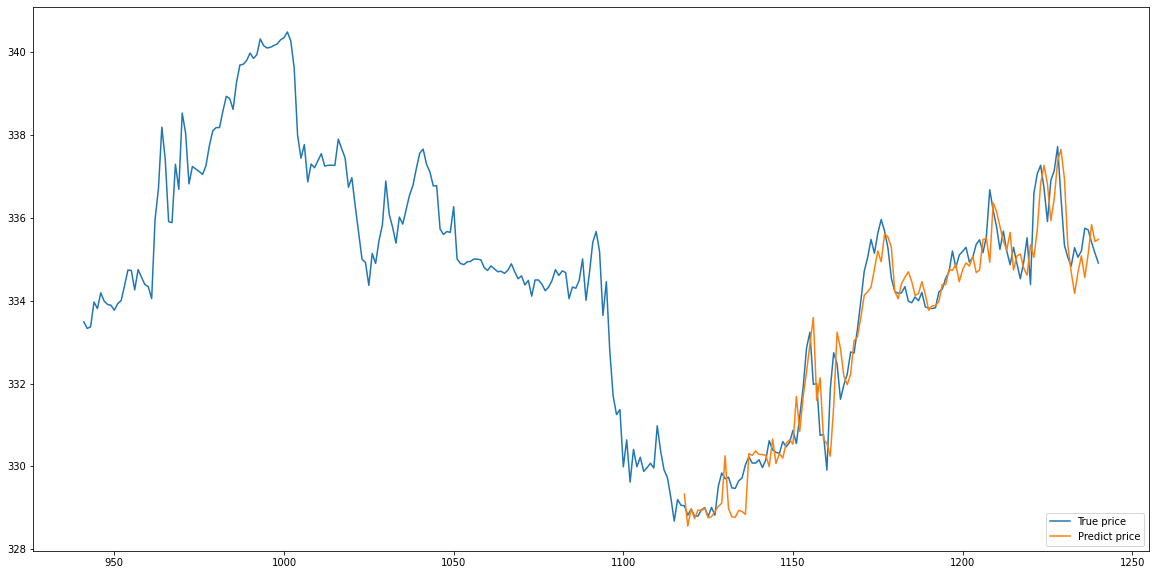

In [95]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


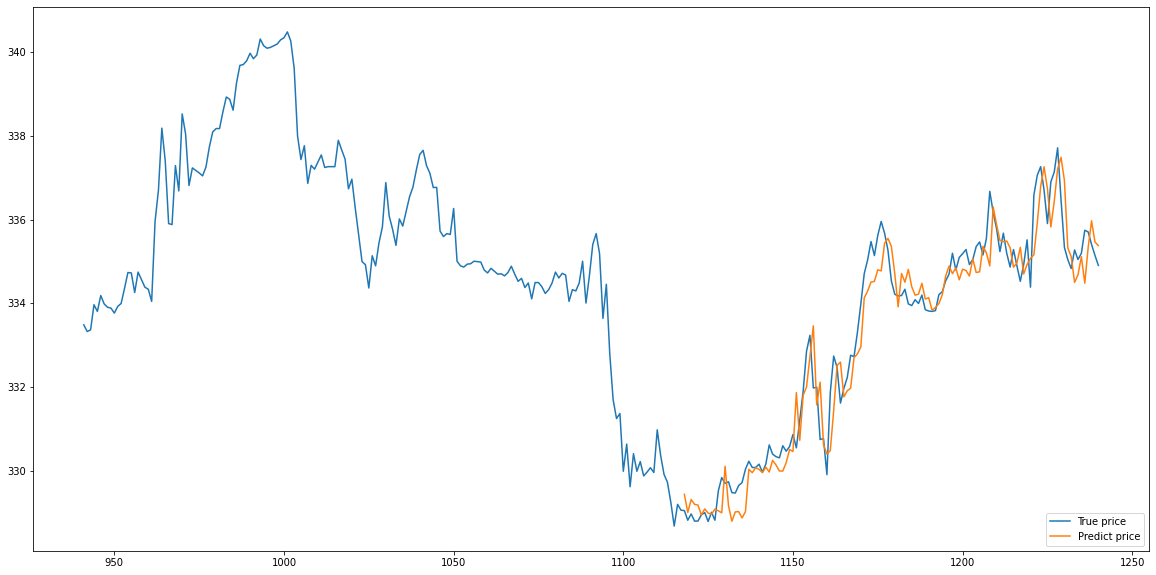

In [96]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

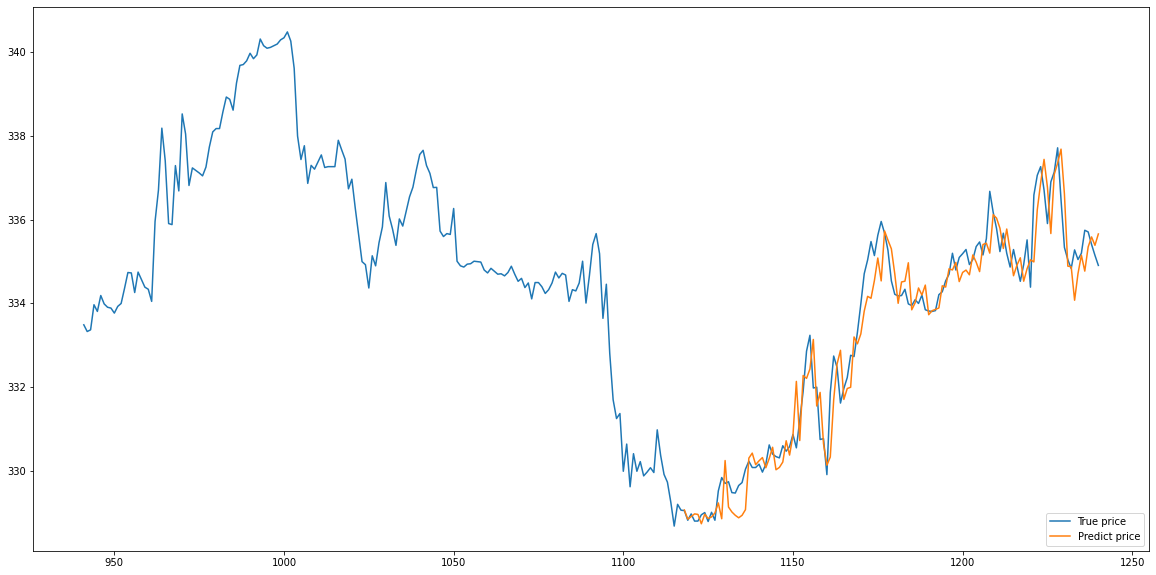

In [97]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

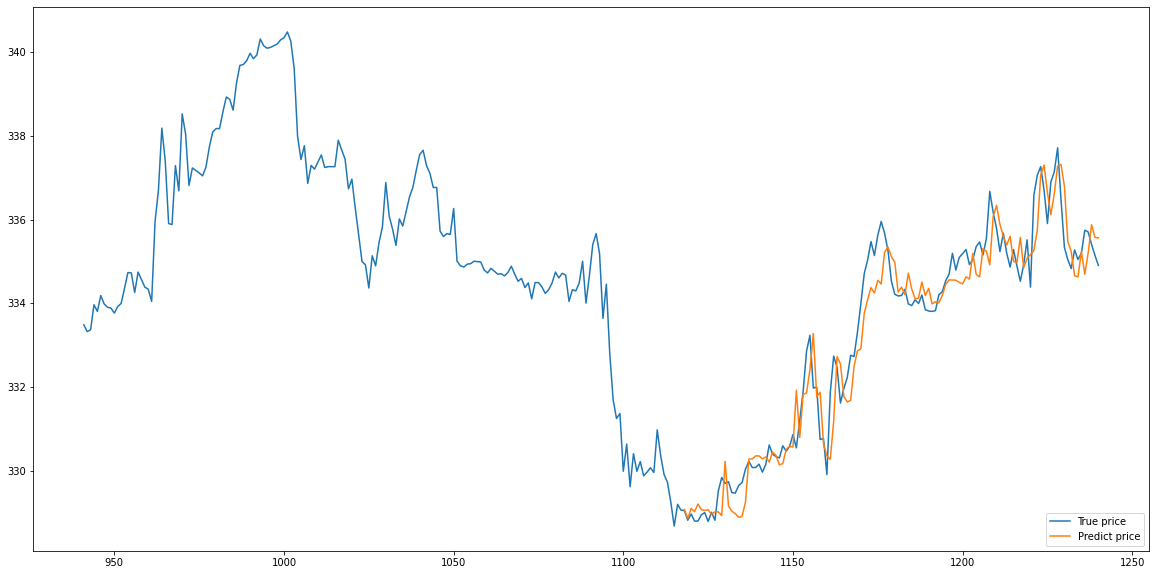

In [98]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

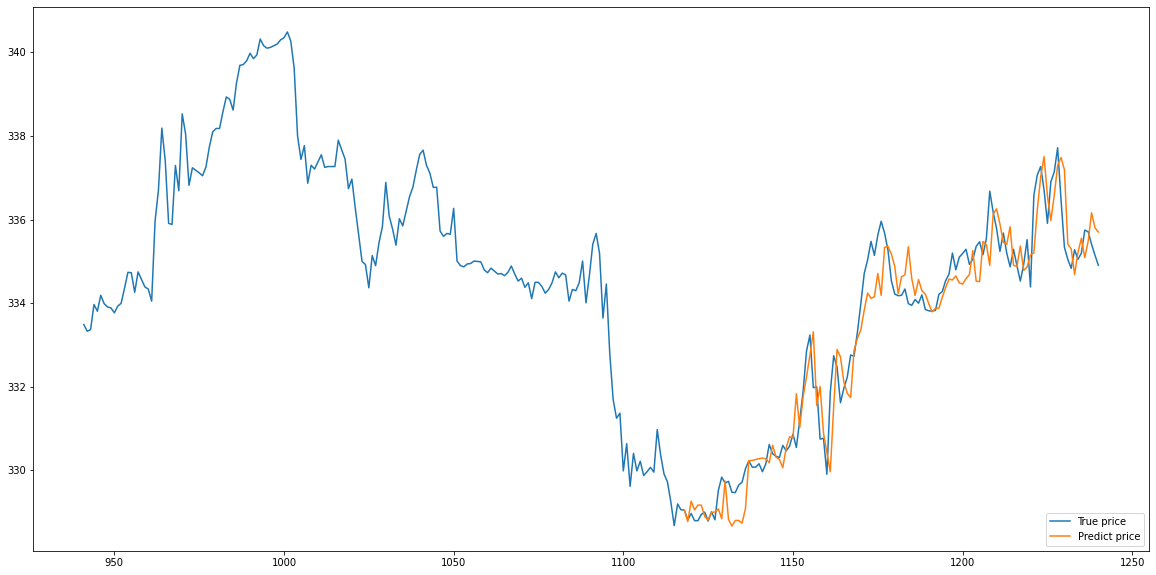

In [99]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

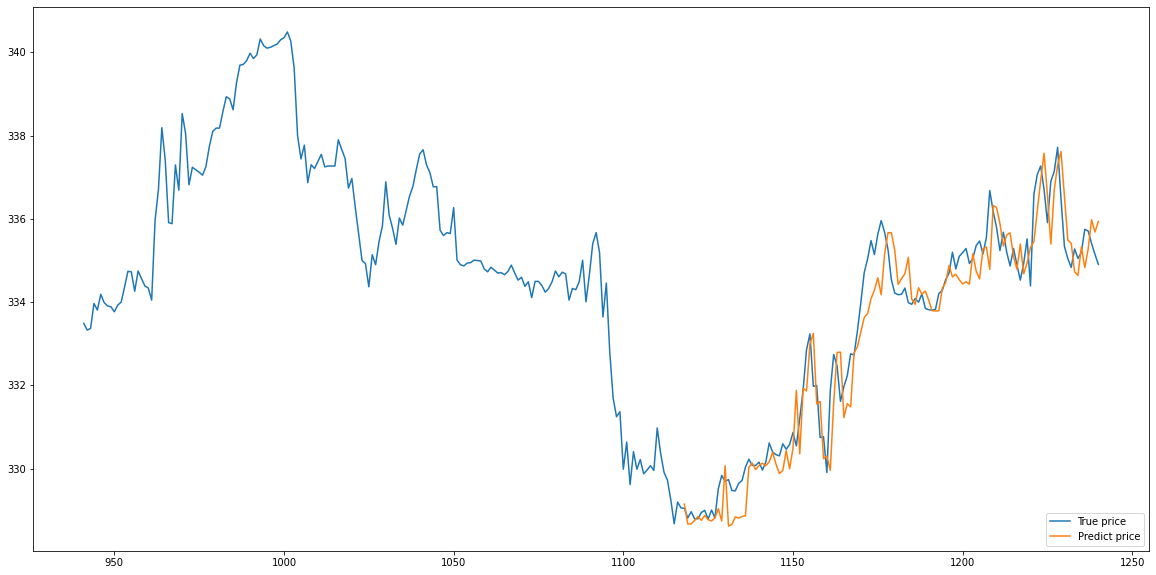

In [100]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

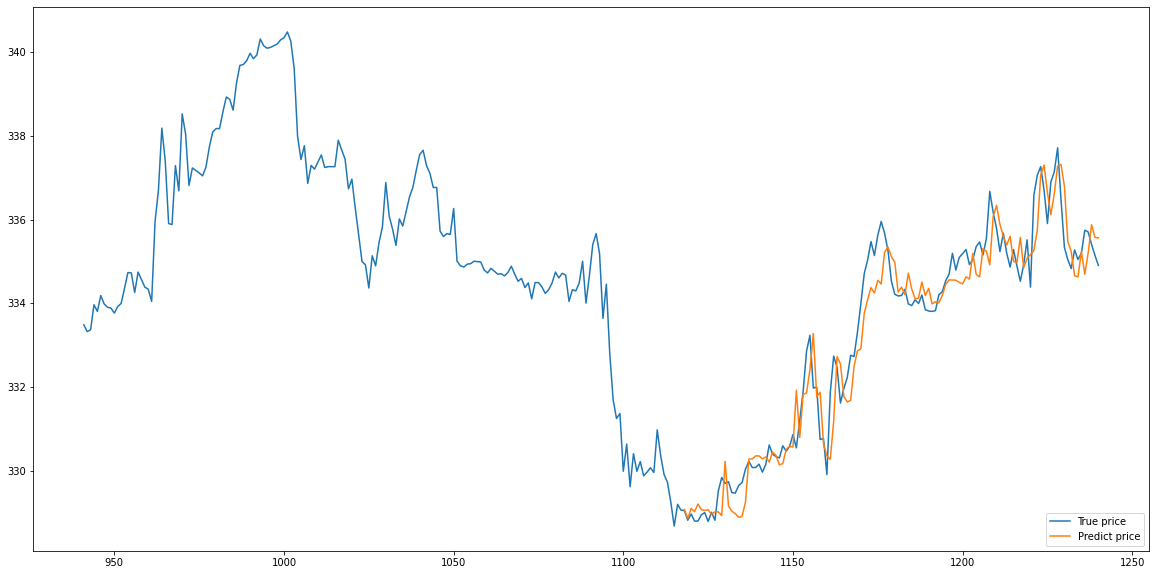

In [101]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

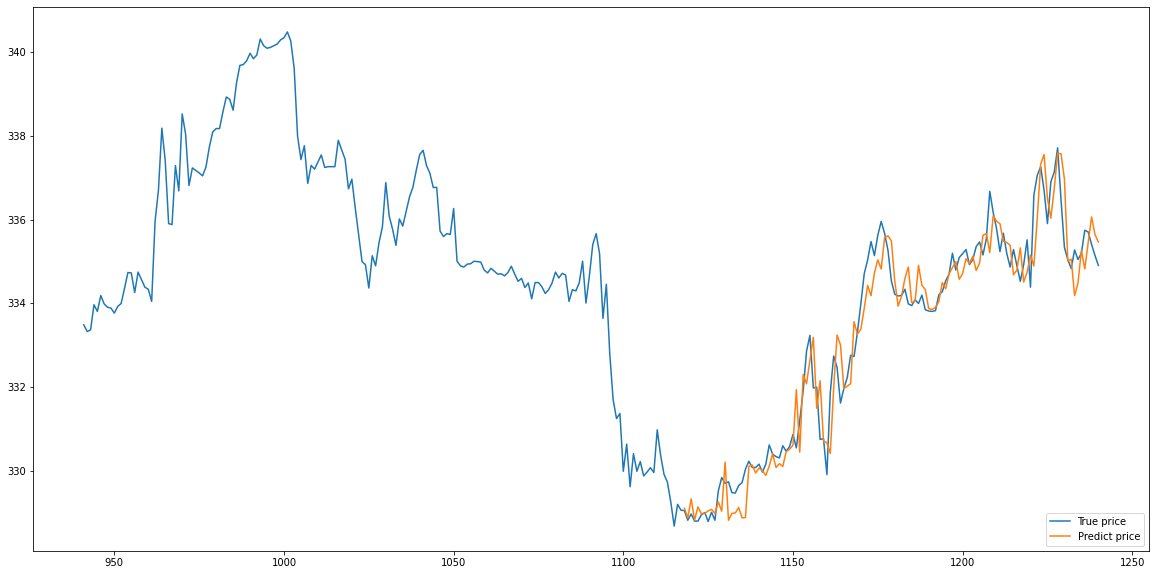

In [102]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

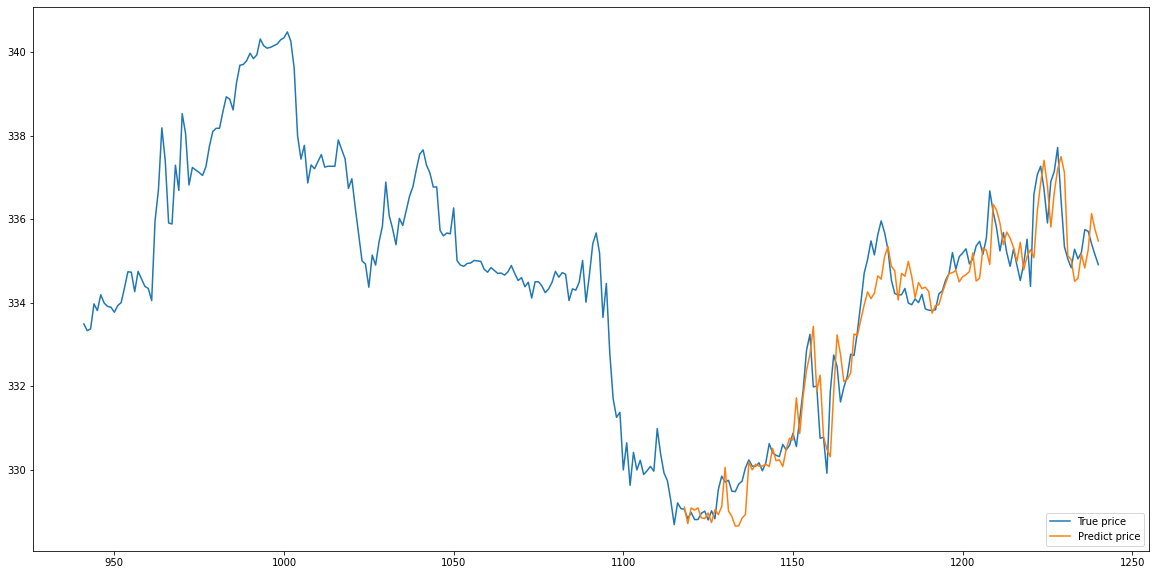

In [103]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

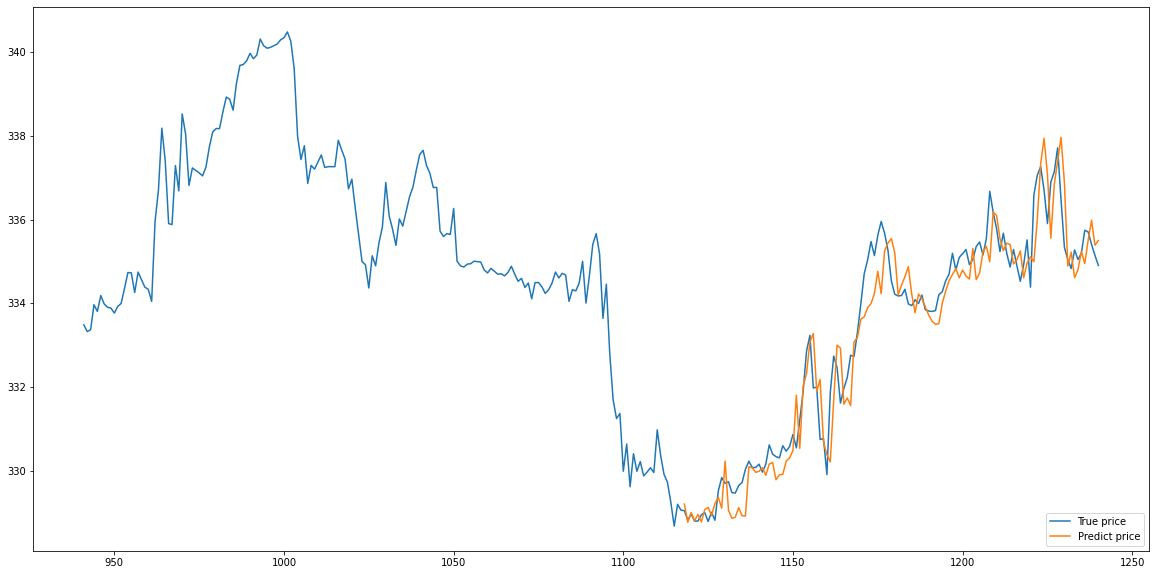

In [104]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

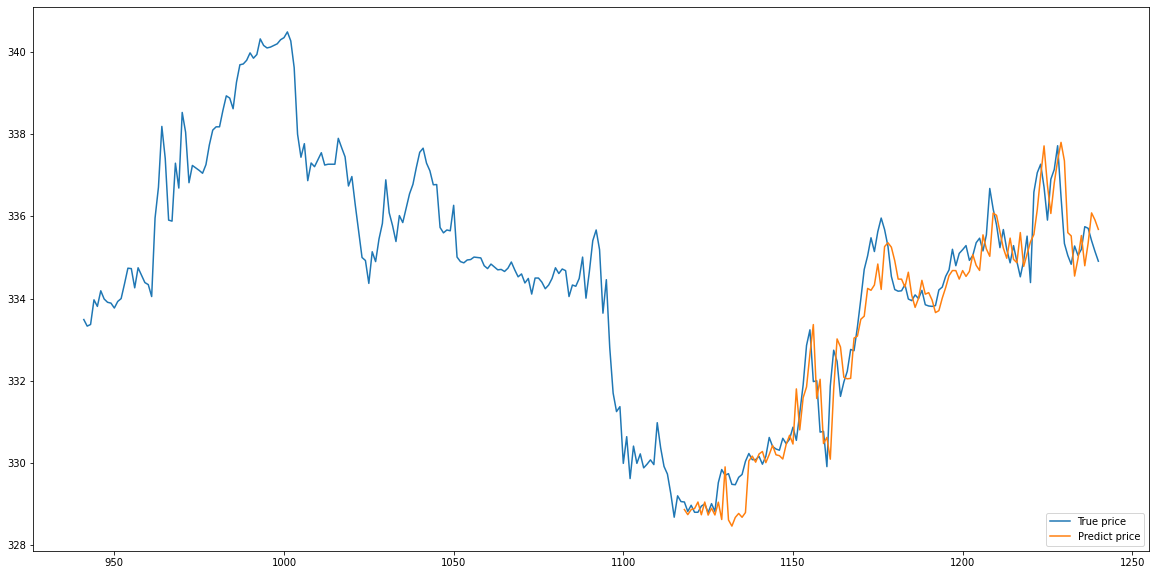

In [105]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

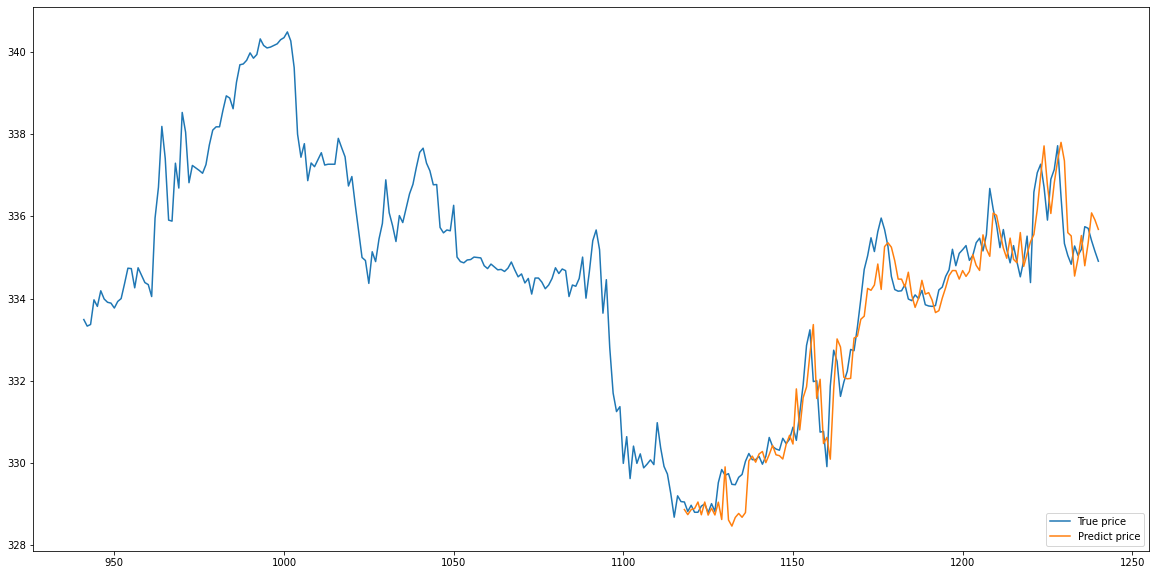

In [106]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

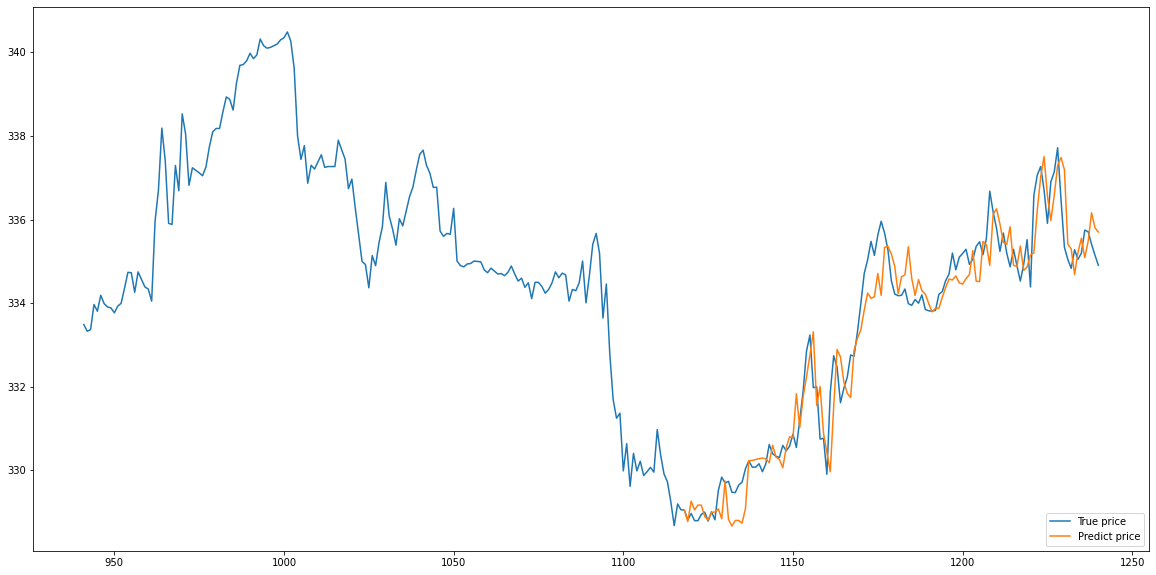

In [107]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

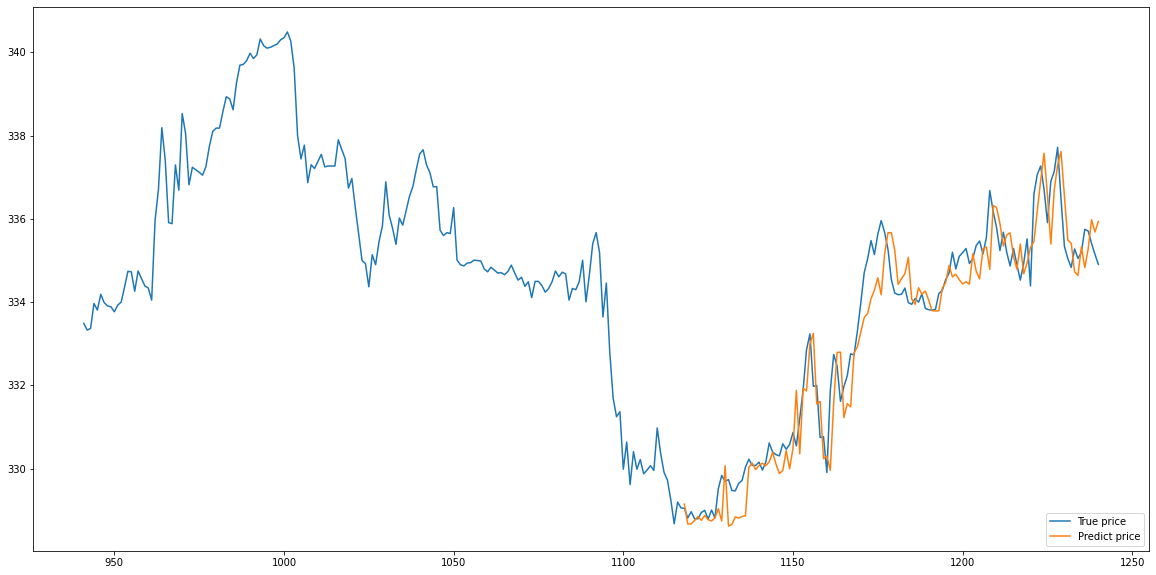

In [108]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

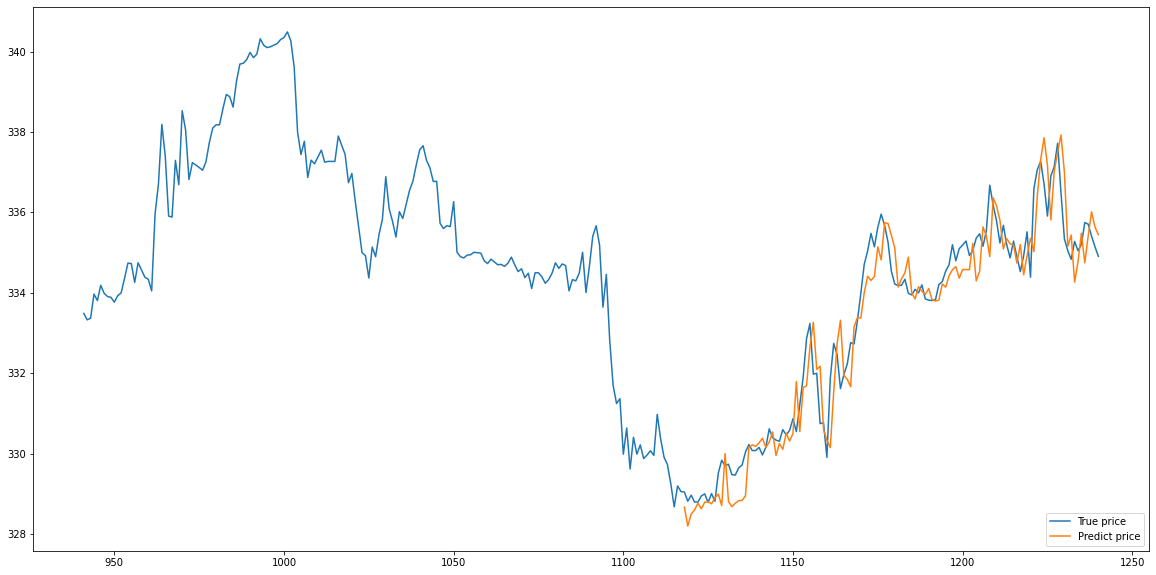

In [109]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

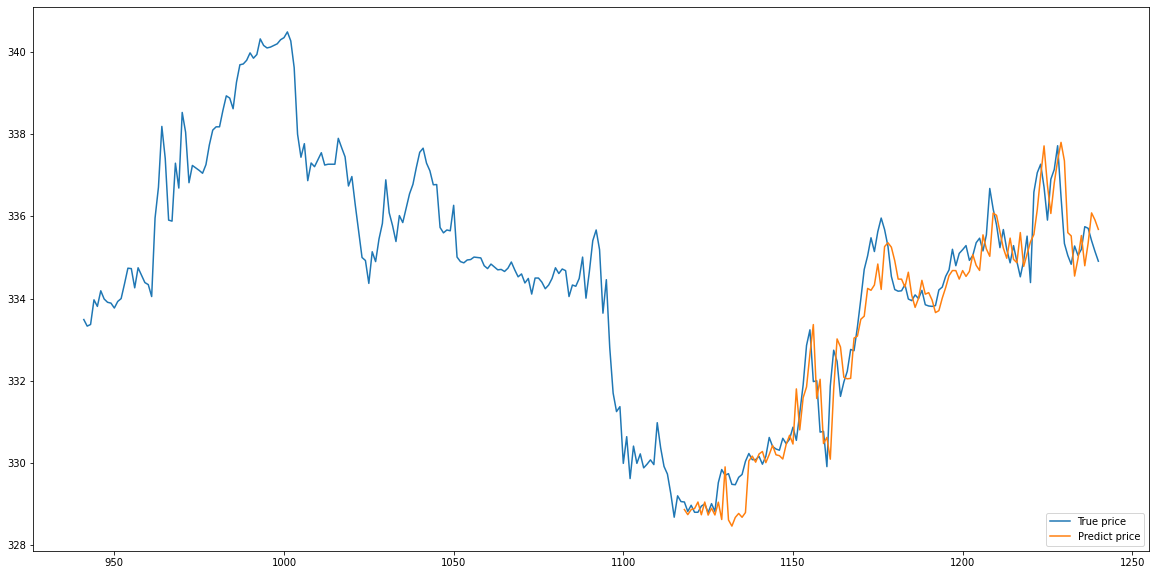

In [110]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [111]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue